In [1]:
import mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pandas_ml
from pandas_ml import ConfusionMatrix

In [2]:
import os
from sklearn.utils import shuffle
import glob
import sys
################### DATASET HANDLING ####################
DATASET_PATH = "/home/dic/jupyter/train_var5_var6" #change the path to your dataset folder here

def parseDataset():
 
    #we use subfolders as class labels
    classes = [folder for folder in sorted(os.listdir(DATASET_PATH))]
 
    #now we enlist all image paths
    images = []
    for c in classes:
        images += ([os.path.join(DATASET_PATH, c, path) for path in os.listdir(os.path.join(DATASET_PATH, c))])
    #print(images)
    #shuffle image paths
    images = shuffle(images, random_state=80)
 
    #we want to use a 15% validation split
    total_len=len(images)
    print("total:",total_len)
    vsplit = int(len(images) * 0.80) #=40
    print("vsplit:",vsplit)
    
    tsplit= int(total_len-vsplit)
    print("tsplit:",tsplit)
    
    gsplit=int(tsplit/2)
    print(gsplit)
    msplit=int(vsplit+gsplit)
    
    
    train = images[:vsplit] #everything except the last vsplit items in the array 
    val = images[vsplit:msplit]  #only last vsplit items from the array
    test=images[msplit:]
    #show some stats
    print ("CLASS LABELS:", classes)
    print ("TRAINING IMAGES:", len(train))
    print ("VALIDATION IMAGES:", len(val))
    print ("TEST IMAGES:", len(test))
    return classes, train, val,test
 
#parse dataset
CLASSES, TRAIN, VAL,TEST = parseDataset()


total: 5932
vsplit: 4745
tsplit: 1187
593
CLASS LABELS: ['var5', 'var6']
TRAINING IMAGES: 4745
VALIDATION IMAGES: 593
TEST IMAGES: 594


In [3]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh

In [4]:
import os
import time
from sklearn.utils import shuffle

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools

from lasagne import random as lasagne_random
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
from lasagne import objectives
from lasagne import updates

import theano
import theano.tensor as T

import warnings
warnings.filterwarnings("ignore")


In [5]:
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
 
################## BUILDING THE MODEL ###################
def buildModel():
    #this is our input layer with the inputs (None, dimensions, width, height)
    l_input = layers.InputLayer((None, 3, 22, 23))
    
    #first convolutional layer, has l_input layer as incoming and is followed by a pooling layer
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=32, filter_size=3, nonlinearity=lasagne.nonlinearities.tanh)
    
    #l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_conv1,  p=0.1)
    
    #l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    #l_conv2 = layers.Conv2DLayer(l_drop1, num_filters=128, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
   
    #l_conv3 = layers.Conv2DLayer(l_conv2, num_filters=256, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_dense2 = layers.DenseLayer(l_drop1, num_units=128)
    
    l_drop2= layers.DropoutLayer(l_dense2,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=128)
    
    l_output = layers.DenseLayer(l_dense2, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
    
    #we return the layer stack as our network by returning the last layer
    return l_output


NET = buildModel()


MODEL HAS 1738114 PARAMS


In [6]:
from lasagne import objectives
 
import theano
import theano.tensor as T
 
#################### LOSS FUNCTION ######################
def calc_loss(prediction, targets):
 
    #categorical crossentropy is the best choice for a multi-class softmax output
    l = T.mean(objectives.categorical_crossentropy(prediction, targets))
    
    return l
 
#theano variable for the class targets
#this is the output vector the net should predict
targets = T.matrix('targets', dtype=theano.config.floatX)
 
#get the network output
prediction = layers.get_output(NET)
 
#calculate the loss
loss = calc_loss(prediction, targets)

In [7]:
################# ACCURACY FUNCTION #####################
def calc_accuracy(prediction, targets):
 
    #we can use the lasagne objective categorical_accuracy to determine the top1 accuracy
    a = T.mean(objectives.categorical_accuracy(prediction, targets, top_k=1))
    
    return a
 
accuracy = calc_accuracy(prediction, targets)

In [8]:
from lasagne import updates
 
####################### UPDATES #########################
#get all trainable parameters (weights) of our net
params = layers.get_all_params(NET, trainable=True)
 
#we use the adam update
#it changes params based on our loss function with the learning rate
param_updates = updates.adam(loss, params, learning_rate=0.0002)

In [9]:
import theano
#################### TRAIN FUNCTION ######################
#the theano train functions takes images and class targets as input
#it updates the parameters of the net and returns the current loss as float value
#compiling theano functions may take a while, you might want to get a coffee now...
print ("COMPILING THEANO TRAIN FUNCTION...",)
train_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], loss, updates=param_updates)
print ("DONE!")
 
################# PREDICTION FUNCTION ####################
#we need the prediction function to calculate the validation accuracy
#this way we can test the net after training
#first we need to get the net output
net_output = layers.get_output(NET)
 
#now we compile another theano function; this may take a while, too
print ("COMPILING THEANO TEST FUNCTION...",)
test_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], [net_output, loss, accuracy])
print ("DONE!")

COMPILING THEANO TRAIN FUNCTION...
DONE!
COMPILING THEANO TEST FUNCTION...
DONE!


In [10]:
import cv2
import numpy as np
 
#################### BATCH HANDLING #####################
def loadImageAndTarget(path):
    #print(path)
    #here we open the image and scale it to 64x64 pixels
    img = cv2.imread(path)
    
    #print(path)
    img = cv2.resize(img, (22, 23))
    
    
    #OpenCV uses BGR instead of RGB, but for now we can ignore that
    #our image has the shape (64, 64, 3) but we need it to be (3, 64, 64)
    img = np.transpose(img, (2, 1, 0))
    
    #we want to use subfolders as class labels
    label = path.split(os.sep[-1])[-2]
    #print(label)
 
    #we need to get the index of our label from CLASSES
    index = CLASSES.index(label)
 
    #allocate array for target
    target = np.zeros((2), dtype='float32')
 
    #we set our target array = 1.0 at our label index, all other entries remain zero
    #Example: if label = dog and dog has index 2 in CLASSES, target looks like: [0.0, 0.0, 1.0, 0.0, 0.0]
    target[index] = 1.0
 
    #we need a 4D-vector for our image and a 2D-vector for our targets
    #we can adjust array dimension with reshape
    img = img.reshape(-1, 3, 22, 23)
    target = target.reshape(-1, 2)
 
    return img, target

In [11]:
#a reasonable size for one batch is 128
BATCH_SIZE = 300
def getDatasetChunk(split):
 
    #get batch-sized chunks of image paths
    for i in range(0, len(split), BATCH_SIZE):
        yield split[i:i+BATCH_SIZE]
        
def getNextImageBatch(split=TRAIN):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_b = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_b = np.zeros((BATCH_SIZE, 2), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        ib = 0
        for path in chunk:
            #load image data and class label from path
            x, y = loadImageAndTarget(path)
 
            #pack into batch array
            x_b[ib] = x
            y_b[ib] = y
            ib += 1
 
        #instead of return, we use yield
        yield x_b[:len(chunk)], y_b[:len(chunk)]

In [12]:

        
def getNextImageBatch1(split=TEST):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_T = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_T = np.zeros((BATCH_SIZE, 2), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        iT = 0
        for path in chunk:
            #load image data and class label from path
            x1, y1 = loadImageAndTarget(path)
 
            #pack into batch array
            x_T[iT] = x1
            y_T[iT] = y1
            iT += 1
 
        #instead of return, we use yield
        yield x_T[:len(chunk)], y_T[:len(chunk)]

In [13]:
cmatrix = []
def clearConfusionMatrix():

    global cmatrix

    #allocate empty matrix of size 5x5 (for our 5 classes)
    cmatrix = np.zeros((len(CLASSES), len(CLASSES)), dtype='int32')
    
    
def updateConfusionMatrix(t, p):
    
    global cmatrix
    cmatrix += confusion_matrix(np.argmax(t, axis=1), np.argmax(p, axis=1))
    
def showConfusionMatrix():

    #new figure
    plt.figure(1)
    plt.clf()

    #show matrix
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    #tick marks
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES)
    plt.yticks(tick_marks, CLASSES)

    #labels
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, cmatrix[i, j], 
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black")

    #axes labels
    plt.ylabel('Target label')
    plt.xlabel('Predicted label')

    #show
    plt.show()
    plt.pause(0.5)   


In [14]:
import matplotlib.pyplot as plt
 
##################### STAT PLOT #########################
plt.ion()
def showChart(epoch, t, v, a):
 
    #new figure
    plt.figure(0)
    plt.clf()
 
    #x-Axis = epoch
    e = range(0, epoch)
 
    #loss subplot
    plt.subplot(211)
    plt.plot(e, train_loss, 'r-', label='Train Loss')
    plt.plot(e, val_loss, 'b-', label='Val Loss')
    plt.ylabel('loss')
 
    #show labels
    plt.legend(loc='upper right', shadow=True)
 
    #accuracy subplot
    plt.subplot(212)
    plt.plot(e, val_accuracy, 'g-')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
 
    #show
    plt.show()
    plt.pause(0.5)

START TRAINING...
EPOCH: 1
TRAIN LOSS: 0.8476484410772307
VAL LOSS: 0.5086584415964693
VAL ACCURACY: 91.3 %
TIME: 8.8 s


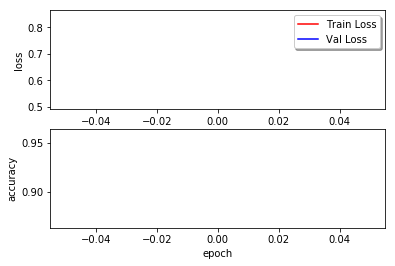

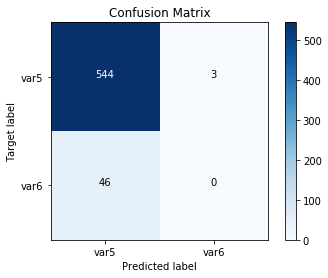

EPOCH: 2
TRAIN LOSS: 0.44160102321799577
VAL LOSS: 0.32267718220595454
VAL ACCURACY: 90.0 %
TIME: 7.6 s


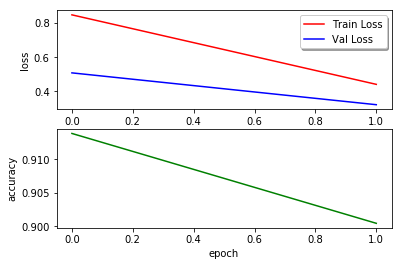

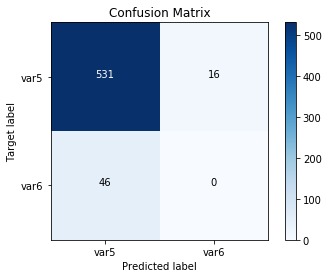

EPOCH: 3
TRAIN LOSS: 0.33638320451511927
VAL LOSS: 0.29808481833211414
VAL ACCURACY: 92.0 %
TIME: 7.6 s


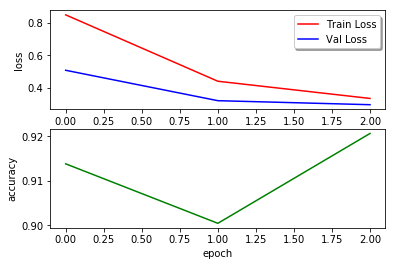

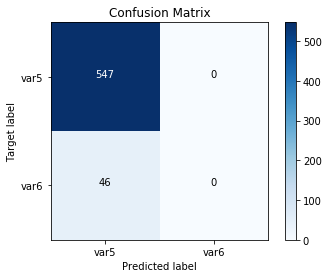

EPOCH: 4
TRAIN LOSS: 0.30249196077136165
VAL LOSS: 0.2691685243662786
VAL ACCURACY: 91.7 %
TIME: 7.8 s


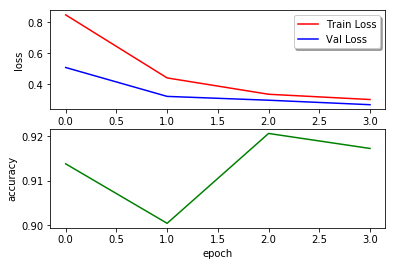

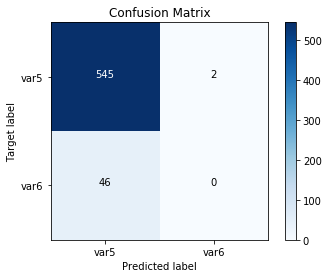

EPOCH: 5
TRAIN LOSS: 0.2802422113666024
VAL LOSS: 0.2552718184832806
VAL ACCURACY: 92.2 %
TIME: 7.8 s


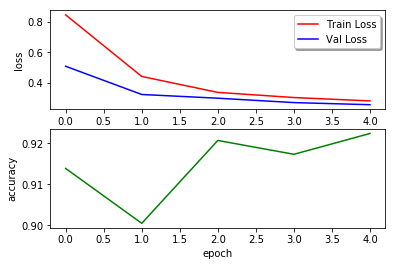

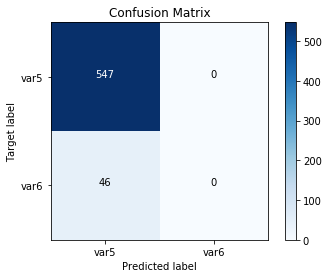

EPOCH: 6
TRAIN LOSS: 0.2722959057022152
VAL LOSS: 0.2411782736779476
VAL ACCURACY: 92.0 %
TIME: 7.9 s


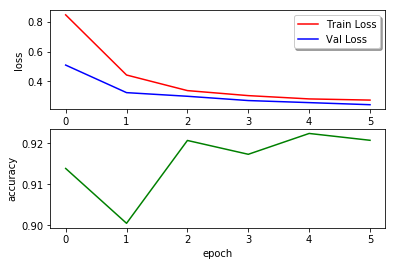

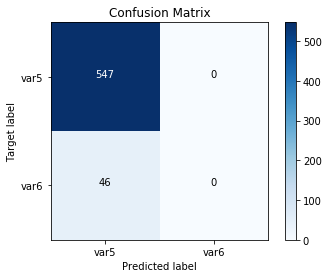

EPOCH: 7
TRAIN LOSS: 0.2619691445652056
VAL LOSS: 0.23184003557195146
VAL ACCURACY: 92.2 %
TIME: 7.7 s


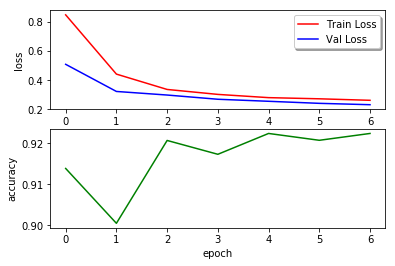

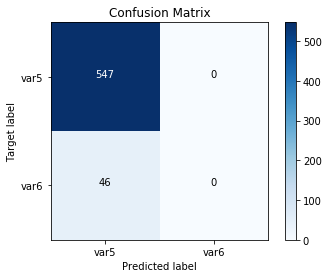

EPOCH: 8
TRAIN LOSS: 0.2506778710985097
VAL LOSS: 0.22998476575313975
VAL ACCURACY: 92.2 %
TIME: 8.1 s


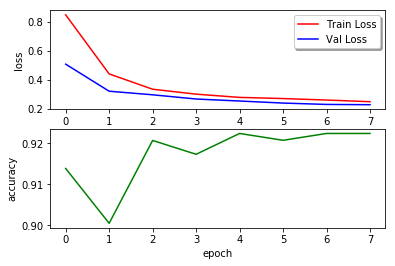

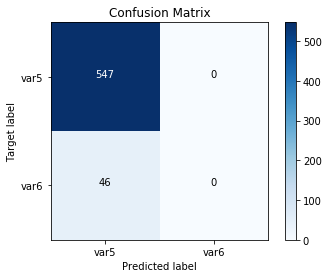

EPOCH: 9
TRAIN LOSS: 0.23486235014427673
VAL LOSS: 0.2107307928197818
VAL ACCURACY: 92.4 %
TIME: 7.7 s


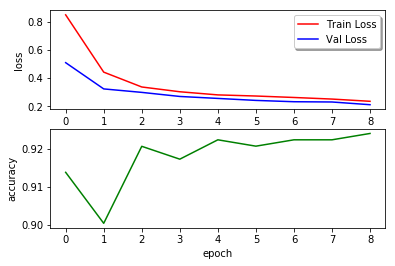

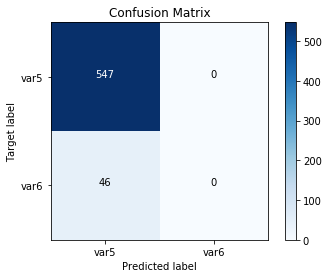

EPOCH: 10
TRAIN LOSS: 0.22404132537656238
VAL LOSS: 0.20156199760039967
VAL ACCURACY: 92.2 %
TIME: 7.8 s


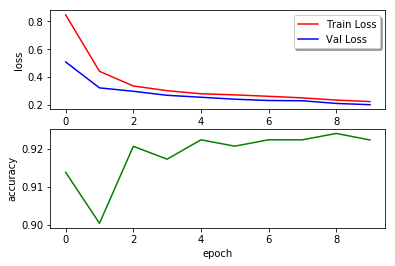

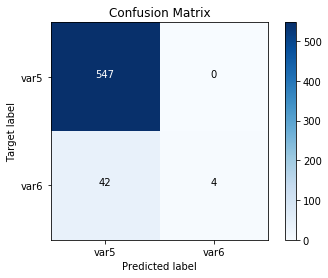

EPOCH: 11
TRAIN LOSS: 0.2021551867550056
VAL LOSS: 0.18508212657405715
VAL ACCURACY: 93.0 %
TIME: 7.8 s


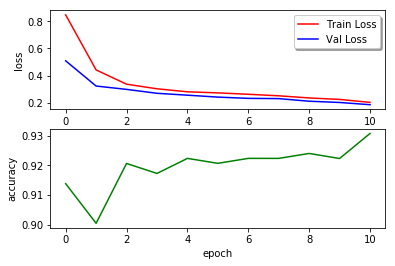

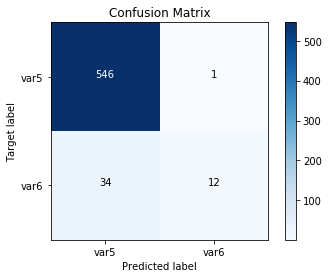

EPOCH: 12
TRAIN LOSS: 0.185277486932453
VAL LOSS: 0.16813015626801847
VAL ACCURACY: 94.2 %
TIME: 7.8 s


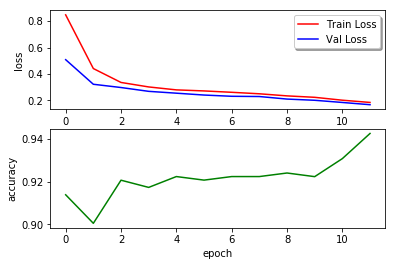

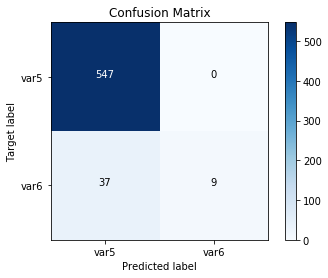

EPOCH: 13
TRAIN LOSS: 0.174065372274832
VAL LOSS: 0.15831557840350702
VAL ACCURACY: 95.2 %
TIME: 7.8 s


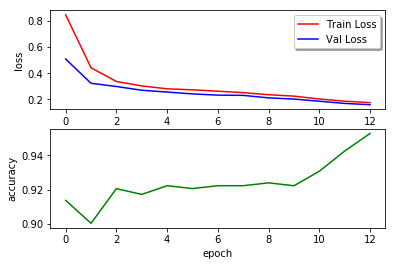

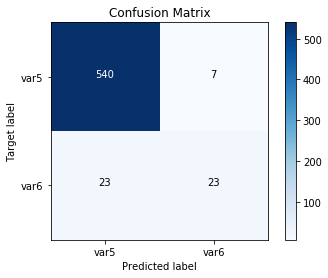

EPOCH: 14
TRAIN LOSS: 0.16134247787630088
VAL LOSS: 0.13134399893513737
VAL ACCURACY: 95.2 %
TIME: 7.8 s


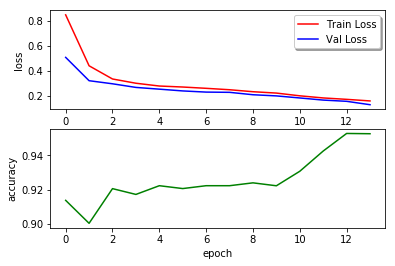

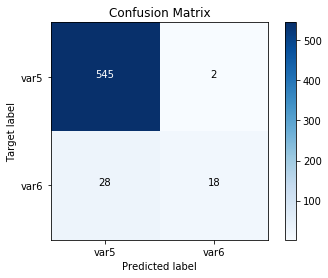

EPOCH: 15
TRAIN LOSS: 0.15375391058747578
VAL LOSS: 0.1456214941087235
VAL ACCURACY: 96.1 %
TIME: 7.8 s


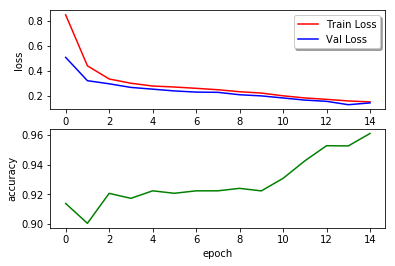

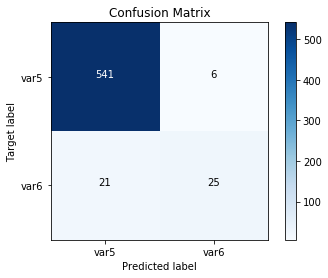

EPOCH: 16
TRAIN LOSS: 0.13440484019339005
VAL LOSS: 0.13312796738445004
VAL ACCURACY: 95.4 %
TIME: 7.8 s


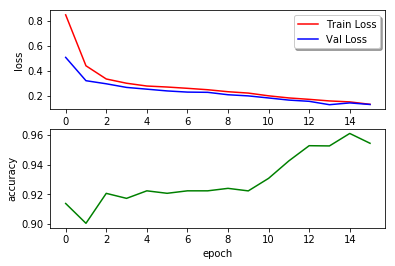

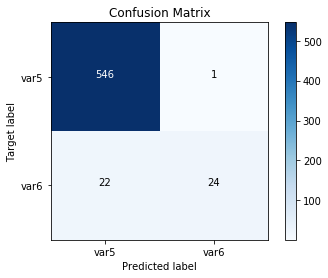

EPOCH: 17
TRAIN LOSS: 0.13374199758224004
VAL LOSS: 0.12175554424416596
VAL ACCURACY: 95.7 %
TIME: 7.9 s


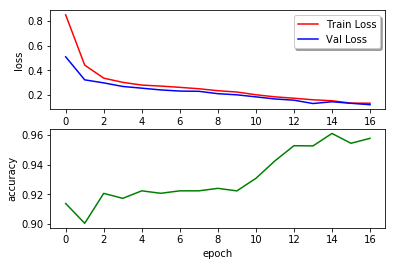

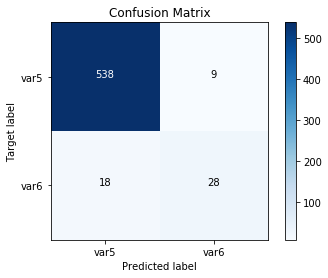

EPOCH: 18
TRAIN LOSS: 0.12546872511154025
VAL LOSS: 0.1214661120614477
VAL ACCURACY: 96.1 %
TIME: 7.7 s


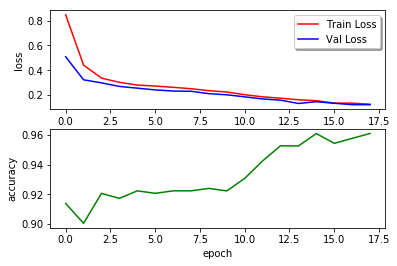

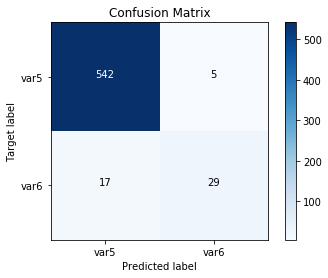

EPOCH: 19
TRAIN LOSS: 0.11438285292671024
VAL LOSS: 0.11760042507709018
VAL ACCURACY: 96.2 %
TIME: 7.7 s


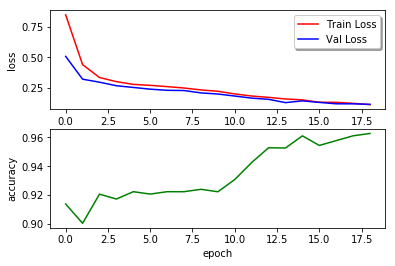

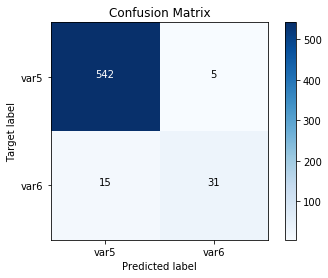

EPOCH: 20
TRAIN LOSS: 0.11430344728435961
VAL LOSS: 0.11396577637898309
VAL ACCURACY: 96.6 %
TIME: 7.7 s


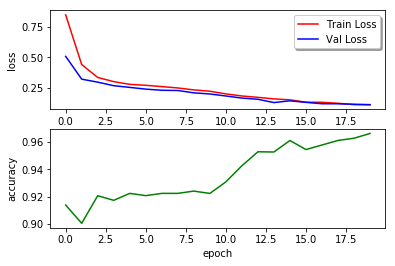

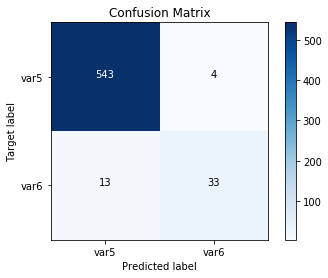

EPOCH: 21
TRAIN LOSS: 0.10994677219962626
VAL LOSS: 0.1052824743899417
VAL ACCURACY: 97.2 %
TIME: 7.7 s


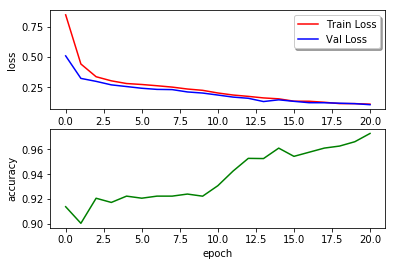

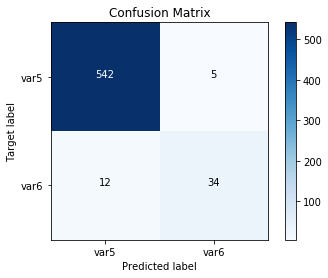

EPOCH: 22
TRAIN LOSS: 0.09869755020483054
VAL LOSS: 0.10463031306672696
VAL ACCURACY: 96.9 %
TIME: 7.7 s


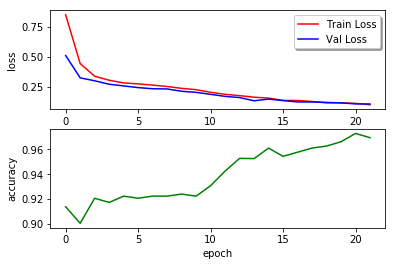

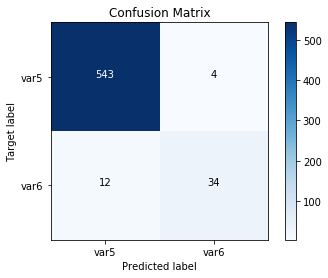

EPOCH: 23
TRAIN LOSS: 0.10504483790758129
VAL LOSS: 0.1133473802467784
VAL ACCURACY: 96.2 %
TIME: 7.6 s


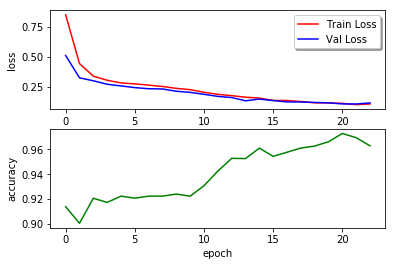

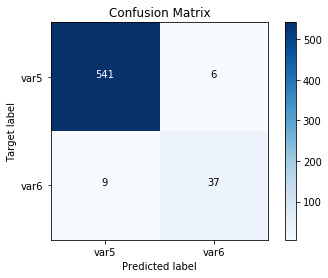

EPOCH: 24
TRAIN LOSS: 0.09496477509353246
VAL LOSS: 0.10167678732897521
VAL ACCURACY: 97.1 %
TIME: 7.7 s


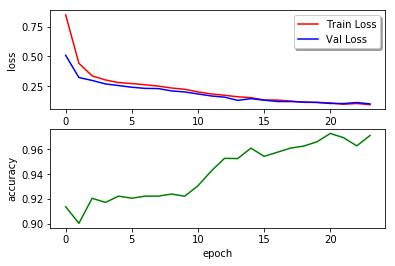

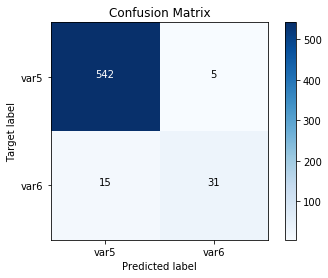

EPOCH: 25
TRAIN LOSS: 0.08828485999340897
VAL LOSS: 0.10191781801697647
VAL ACCURACY: 97.1 %
TIME: 7.7 s


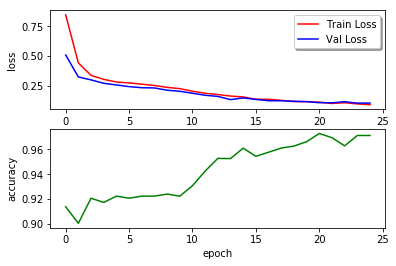

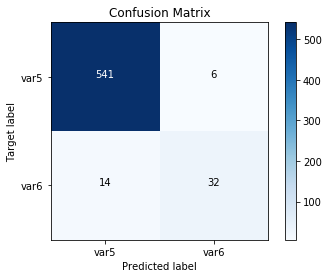

EPOCH: 26
TRAIN LOSS: 0.08265098302454886
VAL LOSS: 0.09743549979514957
VAL ACCURACY: 97.1 %
TIME: 7.7 s


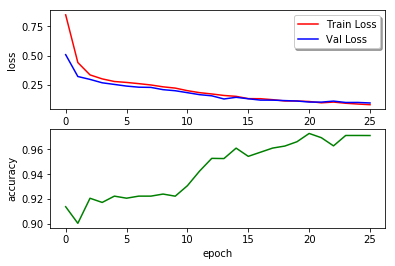

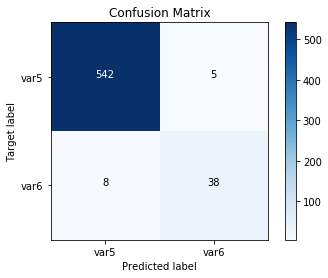

EPOCH: 27
TRAIN LOSS: 0.08380562767822444
VAL LOSS: 0.08698591994948217
VAL ACCURACY: 97.2 %
TIME: 7.7 s


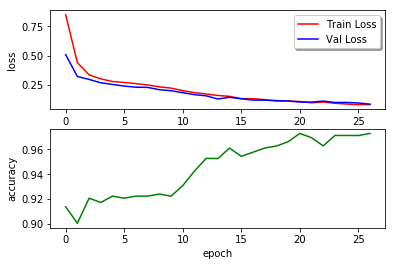

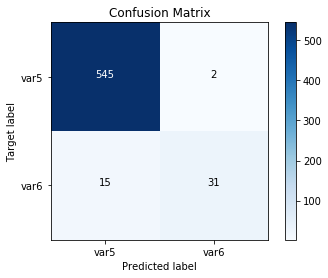

EPOCH: 28
TRAIN LOSS: 0.07504419475617355
VAL LOSS: 0.10188905096365851
VAL ACCURACY: 97.2 %
TIME: 7.7 s


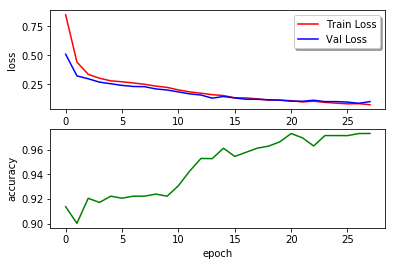

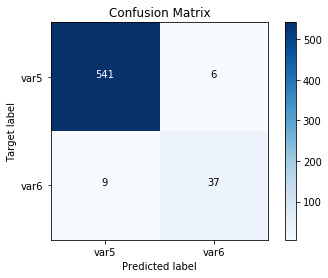

EPOCH: 29
TRAIN LOSS: 0.07333274684342204
VAL LOSS: 0.08947308408893156
VAL ACCURACY: 97.2 %
TIME: 7.7 s


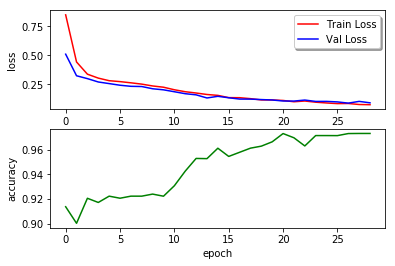

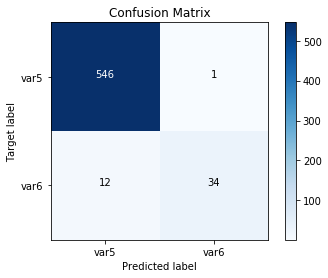

EPOCH: 30
TRAIN LOSS: 0.08242496740802527
VAL LOSS: 0.08971845872341647
VAL ACCURACY: 97.9 %
TIME: 7.7 s


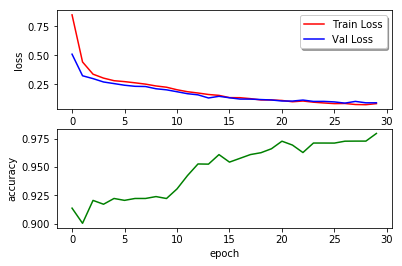

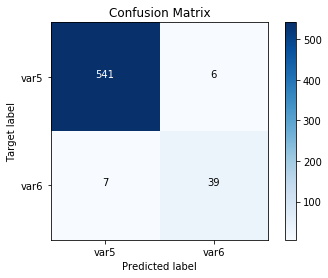

EPOCH: 31
TRAIN LOSS: 0.07713428301284843
VAL LOSS: 0.08652627925166273
VAL ACCURACY: 97.9 %
TIME: 7.7 s


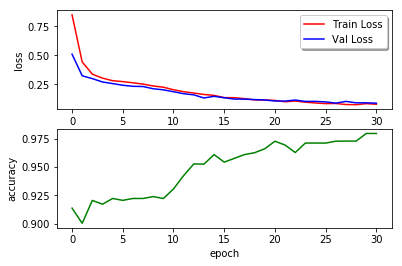

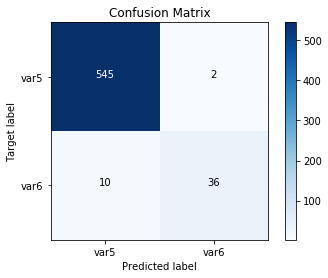

EPOCH: 32
TRAIN LOSS: 0.07335865915890007
VAL LOSS: 0.08894459677877217
VAL ACCURACY: 97.1 %
TIME: 7.7 s


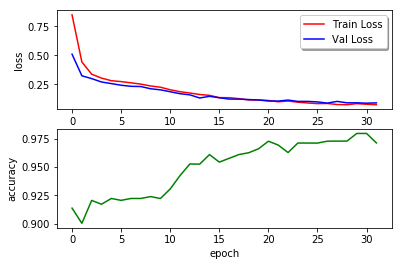

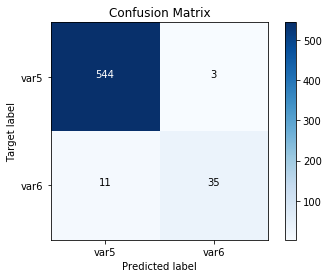

EPOCH: 33
TRAIN LOSS: 0.0629824857619234
VAL LOSS: 0.09294498327614795
VAL ACCURACY: 96.7 %
TIME: 7.8 s


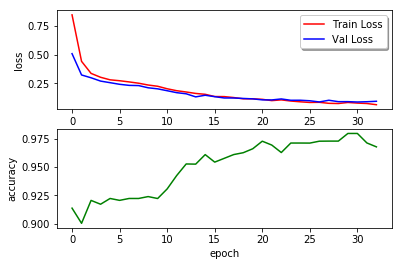

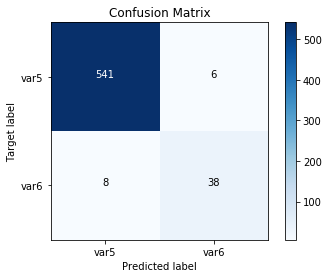

EPOCH: 34
TRAIN LOSS: 0.06429436881921559
VAL LOSS: 0.06820638791526556
VAL ACCURACY: 97.9 %
TIME: 8.0 s


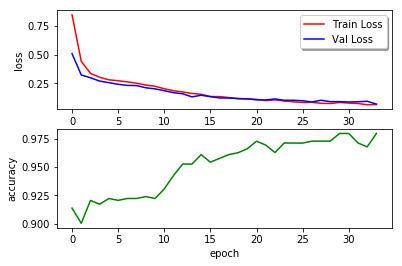

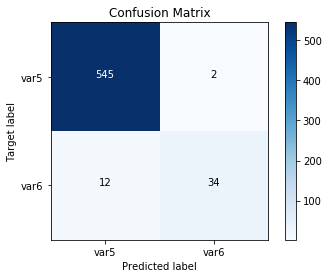

EPOCH: 35
TRAIN LOSS: 0.05941110527798853
VAL LOSS: 0.08945338798775103
VAL ACCURACY: 97.2 %
TIME: 7.7 s


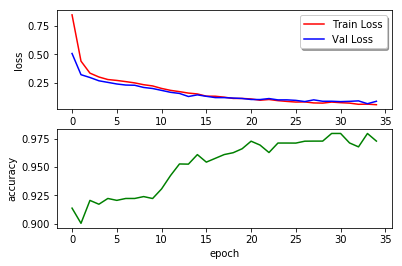

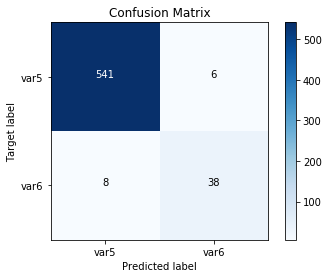

EPOCH: 36
TRAIN LOSS: 0.053520120469673305
VAL LOSS: 0.09288753056501496
VAL ACCURACY: 97.2 %
TIME: 8.3 s


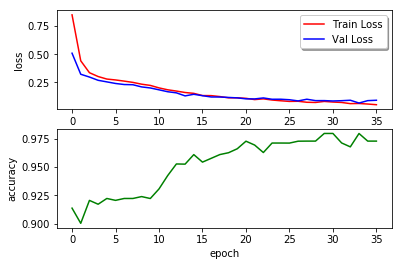

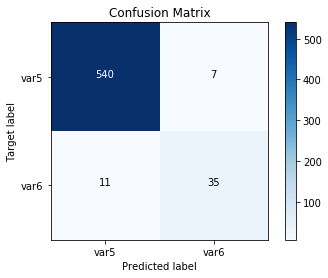

EPOCH: 37
TRAIN LOSS: 0.054438182465463
VAL LOSS: 0.08989940165479746
VAL ACCURACY: 97.1 %
TIME: 9.2 s


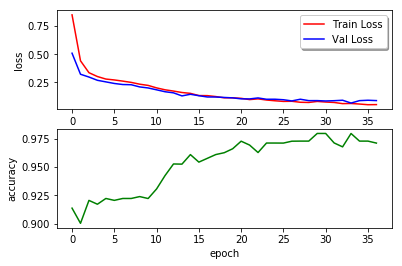

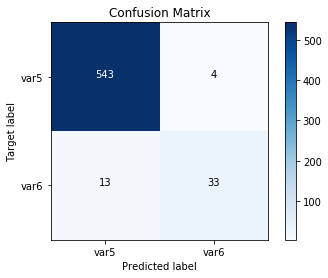

EPOCH: 38
TRAIN LOSS: 0.06520382048819061
VAL LOSS: 0.08644111037937499
VAL ACCURACY: 97.1 %
TIME: 8.1 s


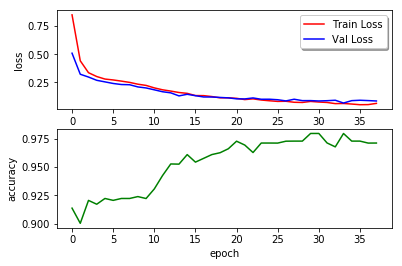

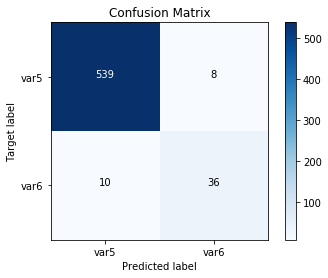

EPOCH: 39
TRAIN LOSS: 0.05625828050492017
VAL LOSS: 0.0788548753056621
VAL ACCURACY: 97.9 %
TIME: 8.0 s


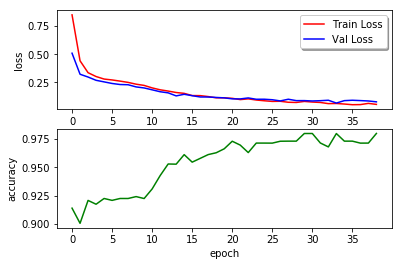

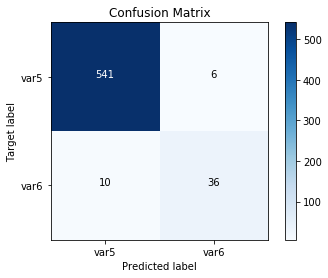

EPOCH: 40
TRAIN LOSS: 0.04827235024917463
VAL LOSS: 0.09404404796281053
VAL ACCURACY: 97.4 %
TIME: 7.8 s


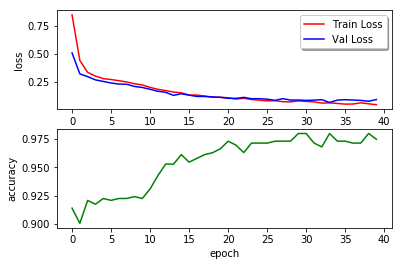

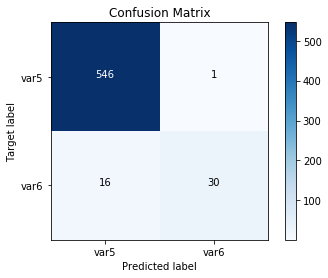

EPOCH: 41
TRAIN LOSS: 0.04675386516043221
VAL LOSS: 0.08095312404756697
VAL ACCURACY: 97.6 %
TIME: 7.7 s


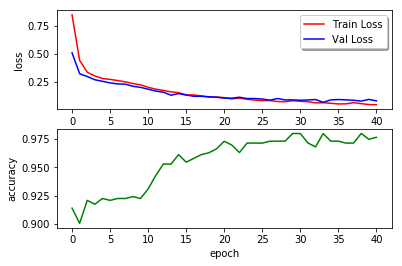

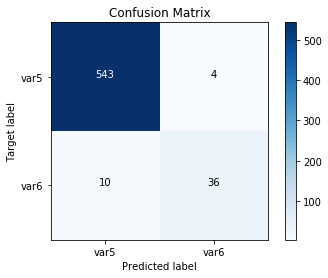

EPOCH: 42
TRAIN LOSS: 0.0448327690394655
VAL LOSS: 0.07604432866419963
VAL ACCURACY: 97.8 %
TIME: 7.7 s


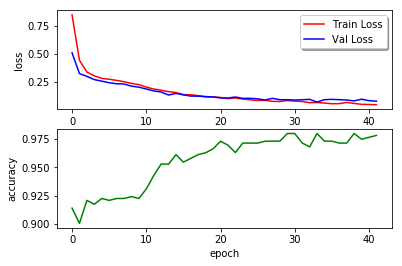

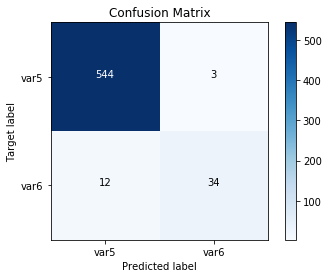

EPOCH: 43
TRAIN LOSS: 0.04781102089901973
VAL LOSS: 0.09383806662579786
VAL ACCURACY: 97.4 %
TIME: 7.7 s


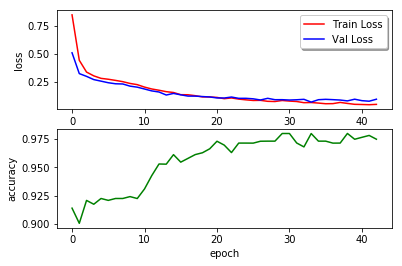

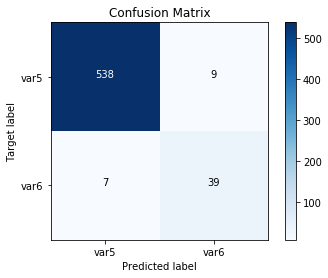

EPOCH: 44
TRAIN LOSS: 0.043038744903363
VAL LOSS: 0.08118091089429741
VAL ACCURACY: 97.2 %
TIME: 7.9 s


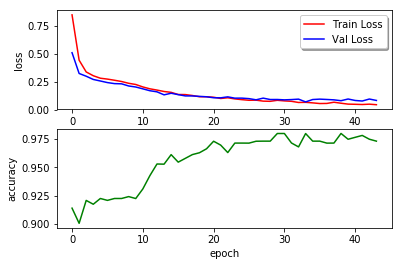

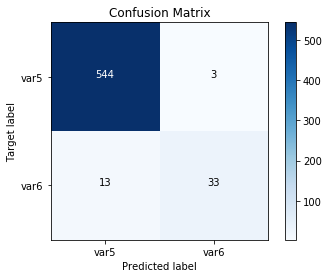

EPOCH: 45
TRAIN LOSS: 0.04288899583502122
VAL LOSS: 0.07197994476189315
VAL ACCURACY: 98.4 %
TIME: 7.9 s


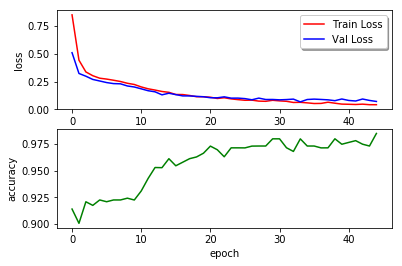

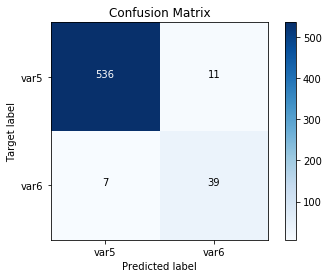

EPOCH: 46
TRAIN LOSS: 0.0405444930242897
VAL LOSS: 0.08711153482444003
VAL ACCURACY: 97.2 %
TIME: 7.8 s


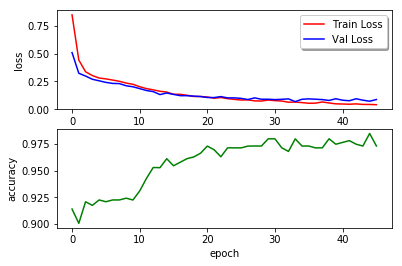

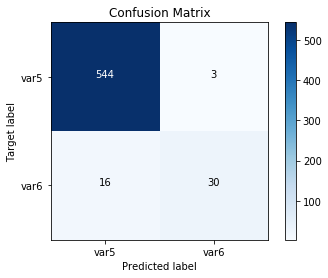

EPOCH: 47
TRAIN LOSS: 0.0433493463224172
VAL LOSS: 0.08047737322331985
VAL ACCURACY: 97.2 %
TIME: 7.9 s


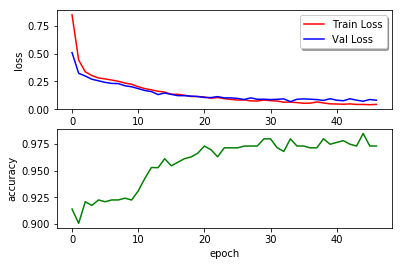

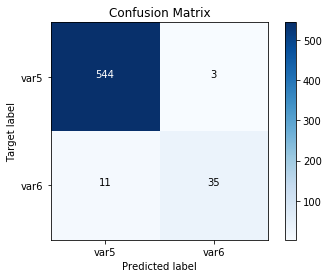

EPOCH: 48
TRAIN LOSS: 0.03553350545025585
VAL LOSS: 0.06920376576579593
VAL ACCURACY: 97.8 %
TIME: 7.9 s


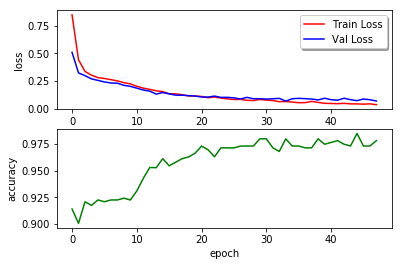

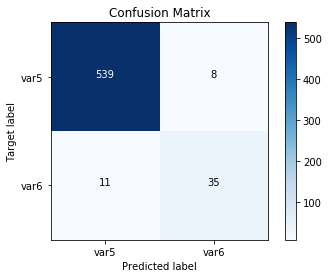

EPOCH: 49
TRAIN LOSS: 0.036987392888132894
VAL LOSS: 0.07352522337516301
VAL ACCURACY: 97.4 %
TIME: 7.7 s


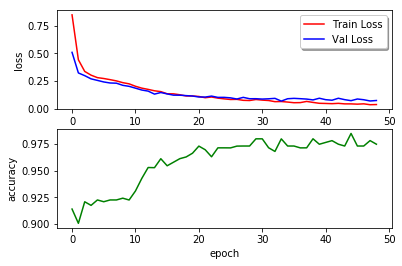

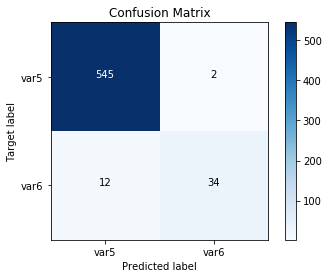

EPOCH: 50
TRAIN LOSS: 0.033382007262097314
VAL LOSS: 0.07119912885650216
VAL ACCURACY: 97.6 %
TIME: 7.9 s


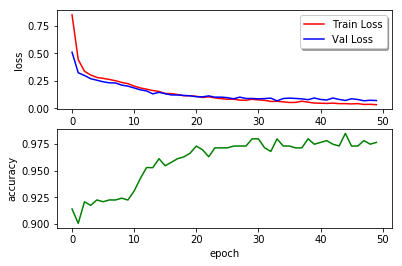

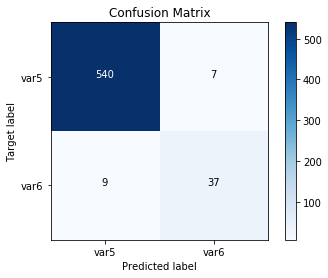

EPOCH: 51
TRAIN LOSS: 0.03636349117575219
VAL LOSS: 0.08242715442023667
VAL ACCURACY: 97.9 %
TIME: 8.4 s


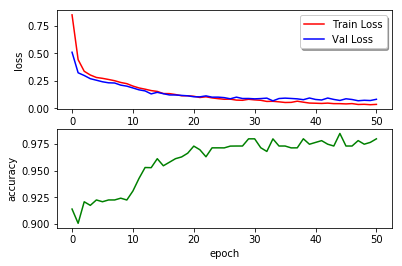

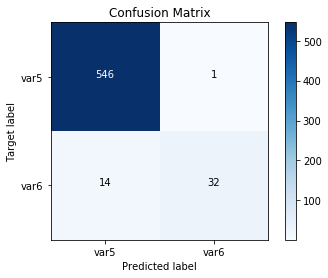

EPOCH: 52
TRAIN LOSS: 0.030940479770107745
VAL LOSS: 0.06944652583062727
VAL ACCURACY: 97.8 %
TIME: 8.1 s


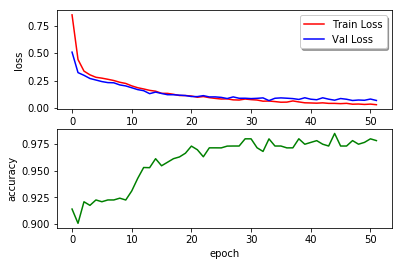

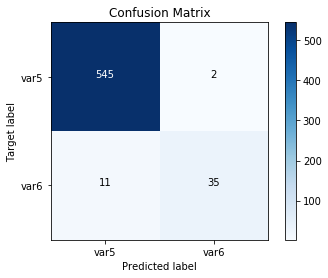

EPOCH: 53
TRAIN LOSS: 0.03490823505028541
VAL LOSS: 0.08304940309190581
VAL ACCURACY: 97.1 %
TIME: 8.5 s


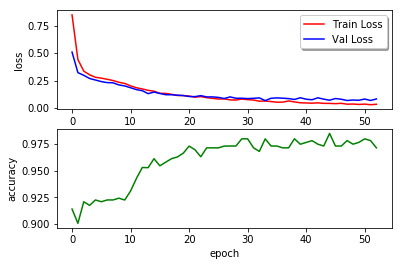

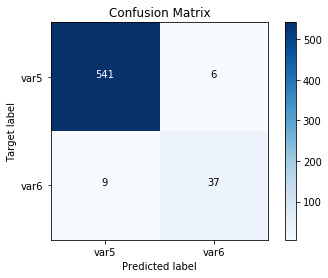

EPOCH: 54
TRAIN LOSS: 0.03458132987493498
VAL LOSS: 0.08402206014690924
VAL ACCURACY: 97.4 %
TIME: 8.1 s


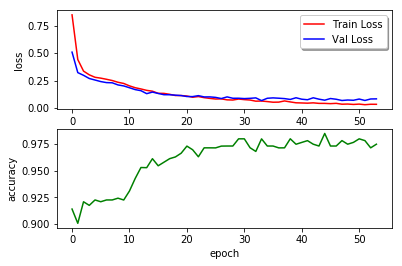

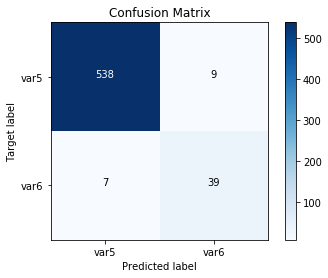

EPOCH: 55
TRAIN LOSS: 0.02824385749006691
VAL LOSS: 0.09786042422172853
VAL ACCURACY: 96.7 %
TIME: 8.3 s


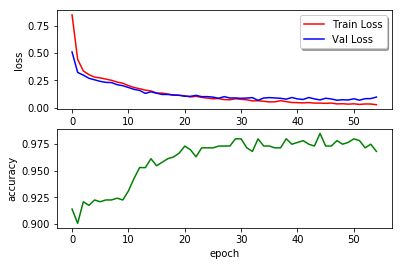

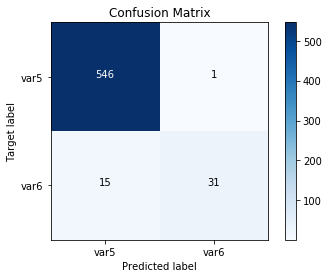

EPOCH: 56
TRAIN LOSS: 0.025249342765614927
VAL LOSS: 0.07363159049970083
VAL ACCURACY: 98.1 %
TIME: 8.4 s


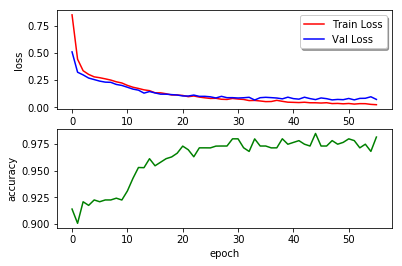

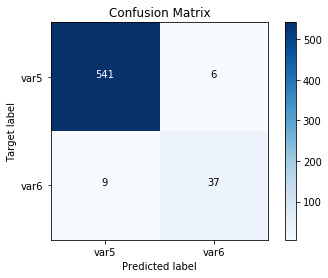

EPOCH: 57
TRAIN LOSS: 0.024270309353071364
VAL LOSS: 0.09078390321062273
VAL ACCURACY: 97.8 %
TIME: 7.8 s


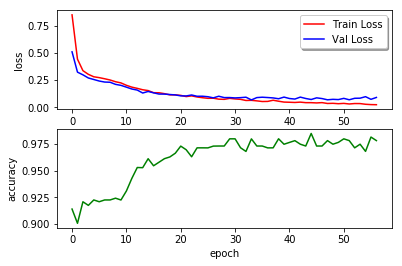

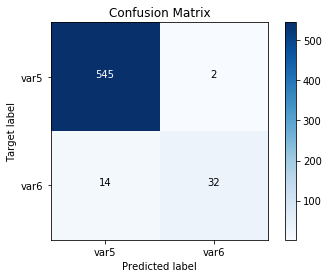

EPOCH: 58
TRAIN LOSS: 0.030604859506641168
VAL LOSS: 0.09794415322396452
VAL ACCURACY: 96.6 %
TIME: 8.0 s


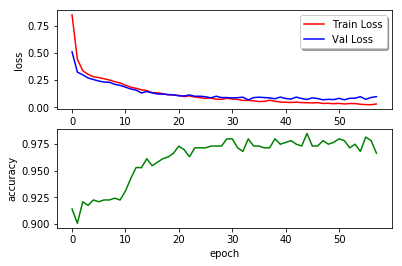

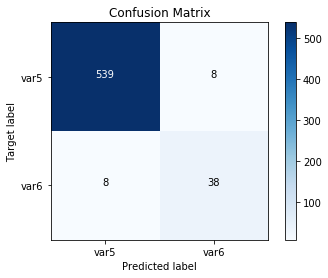

EPOCH: 59
TRAIN LOSS: 0.028278273292142657
VAL LOSS: 0.0683527166025947
VAL ACCURACY: 97.9 %
TIME: 12.3 s


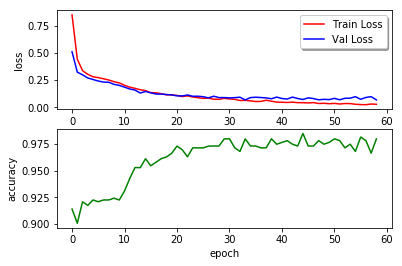

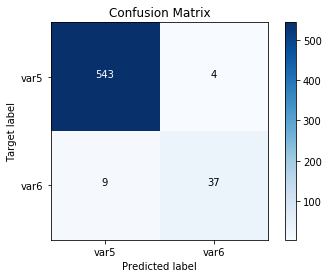

EPOCH: 60
TRAIN LOSS: 0.026461197028909596
VAL LOSS: 0.08302457692199774
VAL ACCURACY: 97.4 %
TIME: 13.7 s


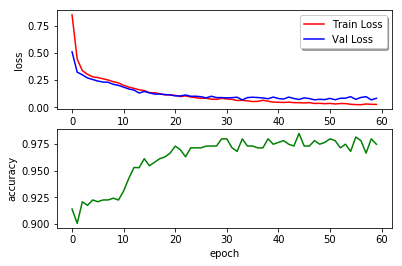

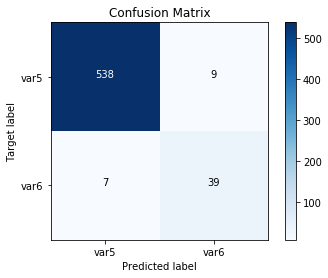

EPOCH: 61
TRAIN LOSS: 0.025755873218992066
VAL LOSS: 0.09242163190501503
VAL ACCURACY: 97.2 %
TIME: 12.8 s


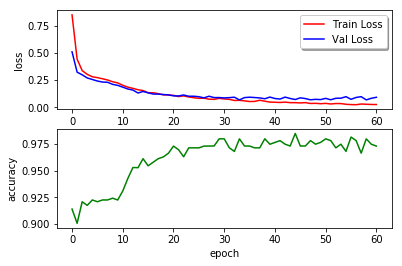

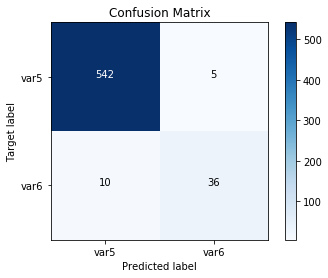

EPOCH: 62
TRAIN LOSS: 0.01991910632849864
VAL LOSS: 0.09873300124147134
VAL ACCURACY: 98.1 %
TIME: 13.8 s


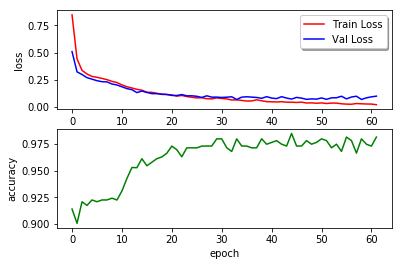

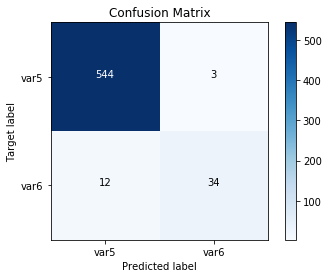

EPOCH: 63
TRAIN LOSS: 0.02221374374221608
VAL LOSS: 0.07580955665294617
VAL ACCURACY: 97.7 %
TIME: 13.8 s


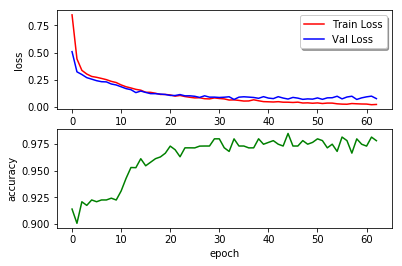

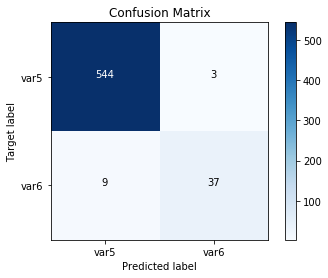

EPOCH: 64
TRAIN LOSS: 0.02047891946965763
VAL LOSS: 0.06137443164949151
VAL ACCURACY: 98.1 %
TIME: 12.7 s


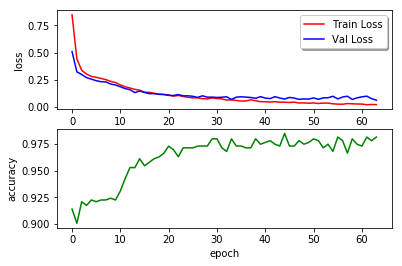

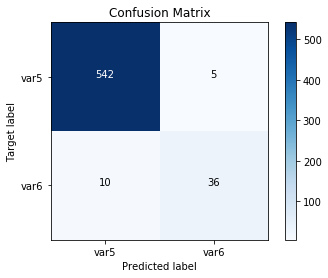

EPOCH: 65
TRAIN LOSS: 0.022086971517051784
VAL LOSS: 0.09293878761292226
VAL ACCURACY: 97.2 %
TIME: 12.7 s


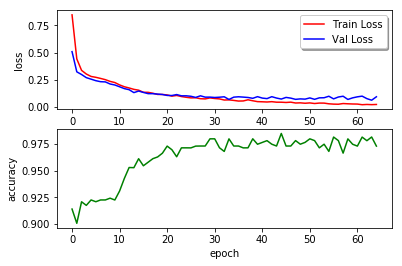

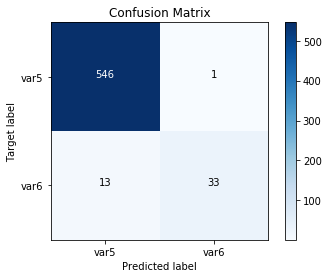

EPOCH: 66
TRAIN LOSS: 0.0216080097704924
VAL LOSS: 0.07136040360712705
VAL ACCURACY: 97.7 %
TIME: 13.1 s


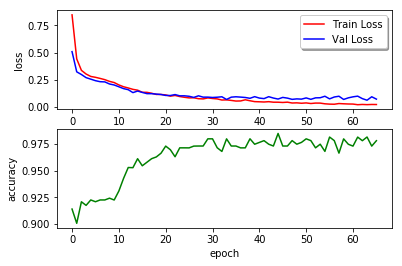

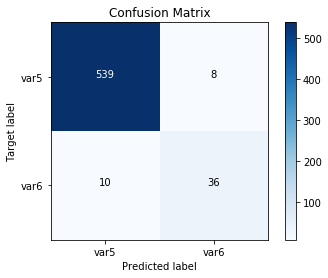

EPOCH: 67
TRAIN LOSS: 0.027857469353881777
VAL LOSS: 0.09693278616151144
VAL ACCURACY: 97.1 %
TIME: 13.6 s


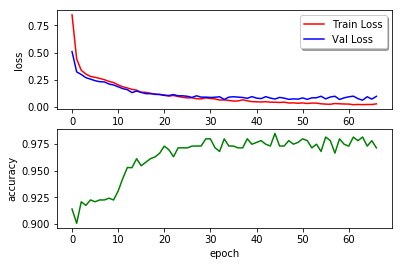

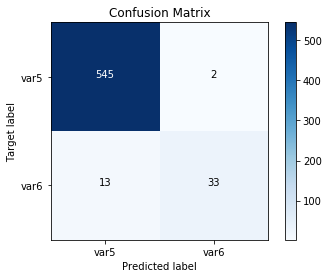

EPOCH: 68
TRAIN LOSS: 0.02326218211381021
VAL LOSS: 0.08073515856615814
VAL ACCURACY: 97.7 %
TIME: 13.0 s


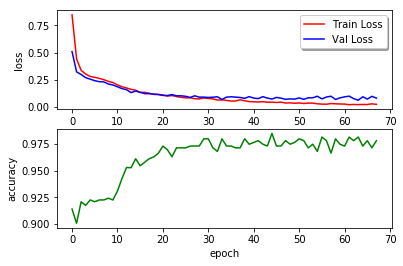

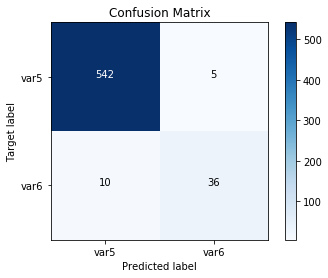

EPOCH: 69
TRAIN LOSS: 0.019163317169873705
VAL LOSS: 0.07463571433390506
VAL ACCURACY: 97.7 %
TIME: 13.2 s


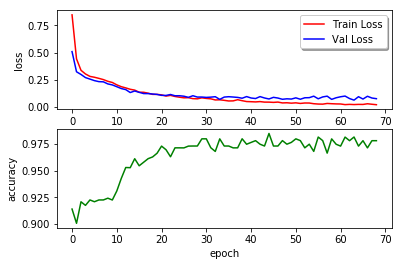

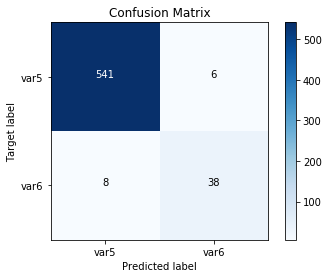

EPOCH: 70
TRAIN LOSS: 0.023242104532560665
VAL LOSS: 0.07811843267663335
VAL ACCURACY: 97.9 %
TIME: 11.8 s


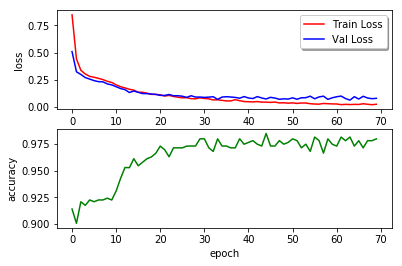

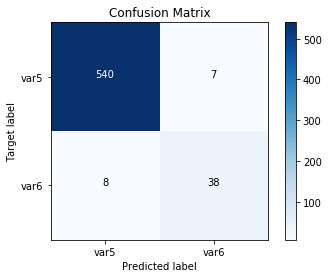

EPOCH: 71
TRAIN LOSS: 0.017215272261604526
VAL LOSS: 0.0847269238666237
VAL ACCURACY: 97.4 %
TIME: 13.0 s


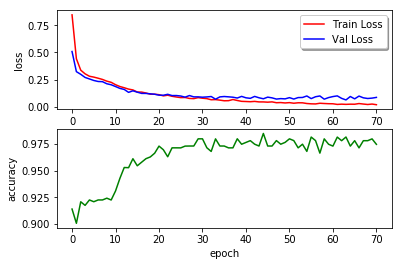

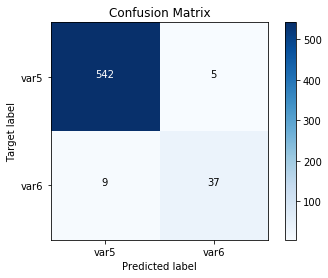

EPOCH: 72
TRAIN LOSS: 0.016164192279864646
VAL LOSS: 0.10431071453994
VAL ACCURACY: 97.1 %
TIME: 11.4 s


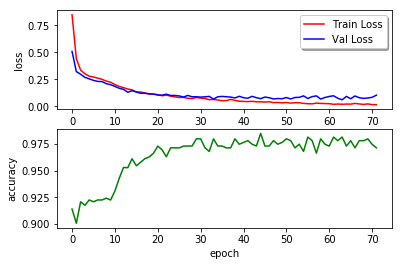

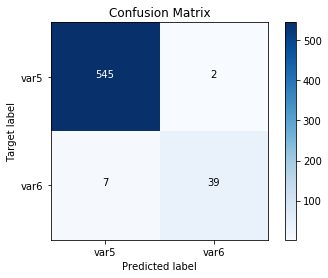

EPOCH: 73
TRAIN LOSS: 0.022187917240253024
VAL LOSS: 0.08881103715782837
VAL ACCURACY: 97.9 %
TIME: 13.8 s


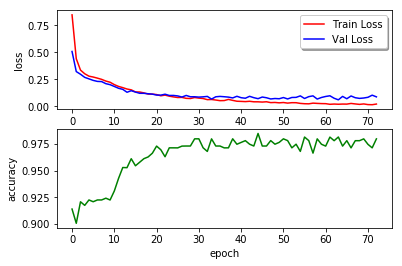

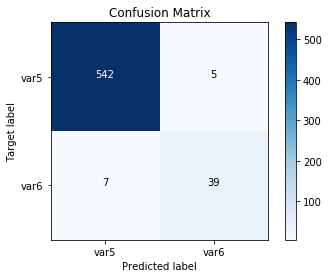

EPOCH: 74
TRAIN LOSS: 0.018072418736145457
VAL LOSS: 0.09900516268381407
VAL ACCURACY: 98.1 %
TIME: 12.0 s


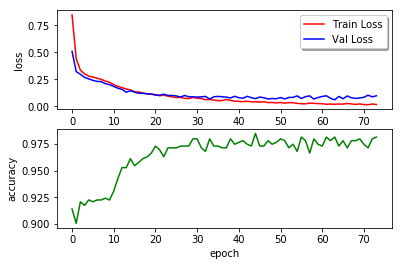

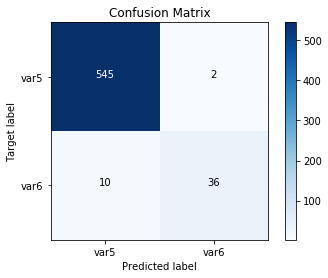

EPOCH: 75
TRAIN LOSS: 0.020222699230966798
VAL LOSS: 0.08457493089711574
VAL ACCURACY: 97.4 %
TIME: 13.4 s


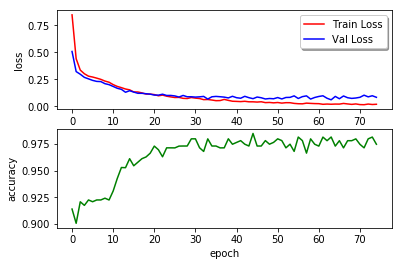

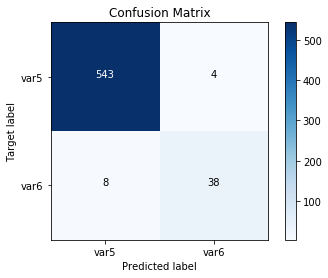

EPOCH: 76
TRAIN LOSS: 0.014423470981331865
VAL LOSS: 0.0674784135326589
VAL ACCURACY: 97.6 %
TIME: 11.6 s


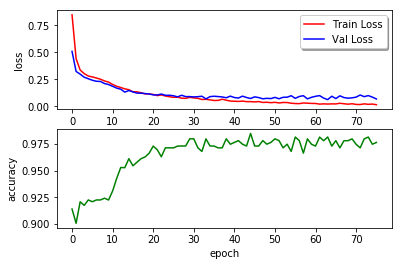

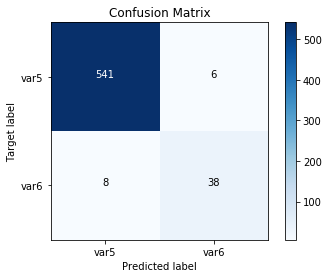

EPOCH: 77
TRAIN LOSS: 0.018693031254817093
VAL LOSS: 0.07035248043911452
VAL ACCURACY: 97.8 %
TIME: 13.1 s


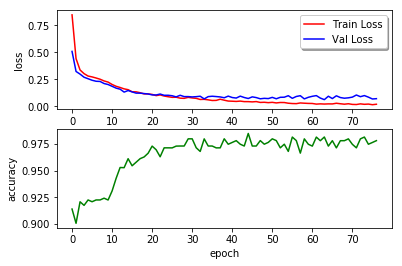

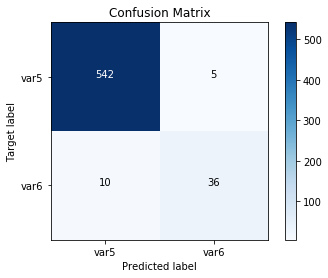

EPOCH: 78
TRAIN LOSS: 0.01641092852635098
VAL LOSS: 0.07727903797061914
VAL ACCURACY: 97.7 %
TIME: 12.5 s


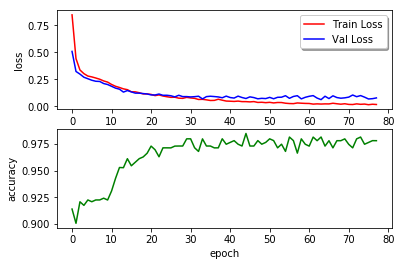

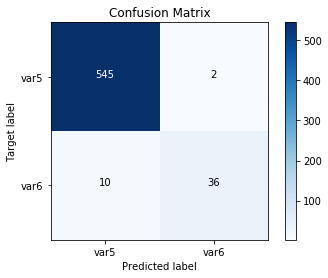

EPOCH: 79
TRAIN LOSS: 0.011565406363651417
VAL LOSS: 0.08732145035253737
VAL ACCURACY: 97.8 %
TIME: 14.0 s


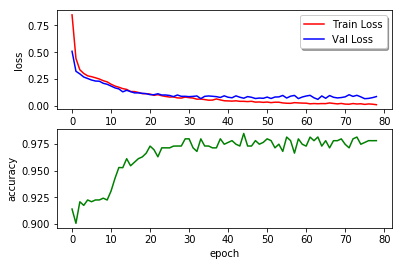

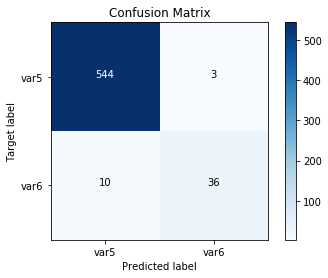

EPOCH: 80
TRAIN LOSS: 0.010870234168935292
VAL LOSS: 0.08570648574400341
VAL ACCURACY: 97.4 %
TIME: 13.5 s


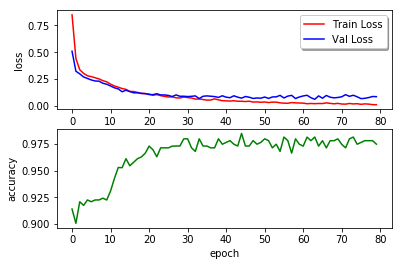

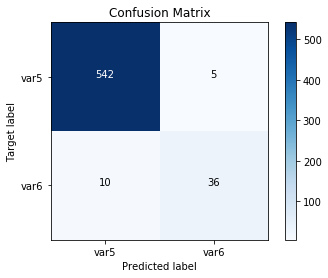

EPOCH: 81
TRAIN LOSS: 0.01797747371796396
VAL LOSS: 0.09722039532936777
VAL ACCURACY: 97.6 %
TIME: 14.0 s


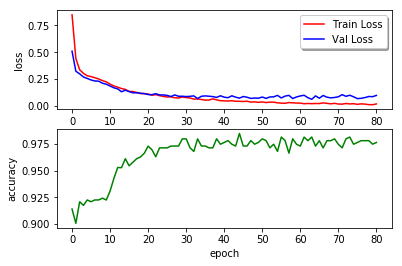

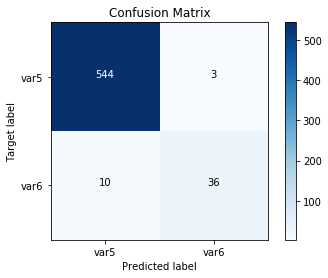

EPOCH: 82
TRAIN LOSS: 0.014295592290922615
VAL LOSS: 0.08526893043699878
VAL ACCURACY: 98.1 %
TIME: 13.4 s


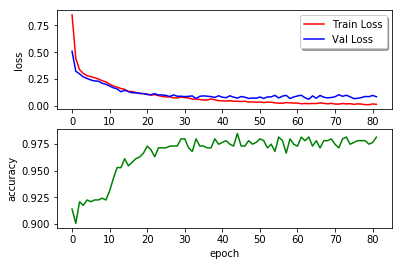

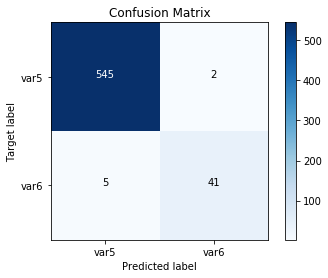

EPOCH: 83
TRAIN LOSS: 0.016705020187645043
VAL LOSS: 0.07987986485527798
VAL ACCURACY: 97.6 %
TIME: 12.5 s


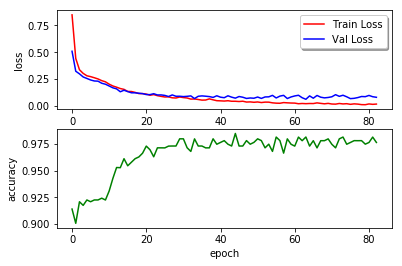

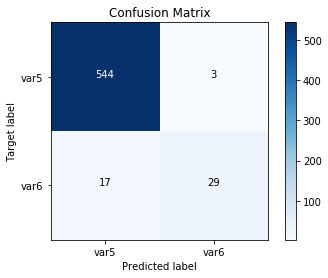

EPOCH: 84
TRAIN LOSS: 0.01583524749388268
VAL LOSS: 0.08820315423842051
VAL ACCURACY: 97.4 %
TIME: 12.5 s


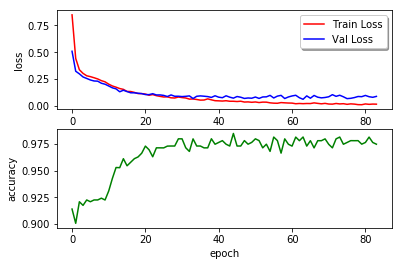

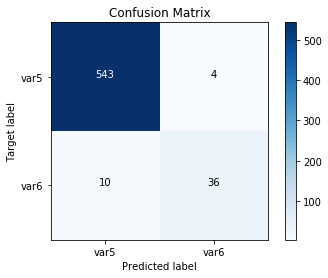

EPOCH: 85
TRAIN LOSS: 0.01600164622730515
VAL LOSS: 0.09514106495351886
VAL ACCURACY: 97.9 %
TIME: 11.9 s


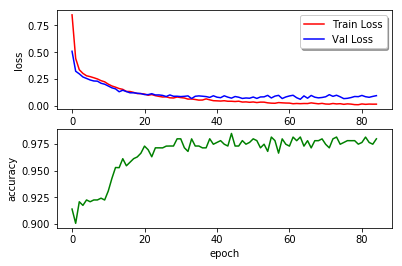

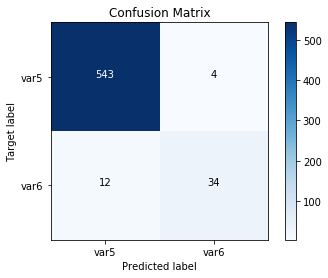

EPOCH: 86
TRAIN LOSS: 0.012911282268843985
VAL LOSS: 0.07213109705185006
VAL ACCURACY: 98.1 %
TIME: 12.9 s


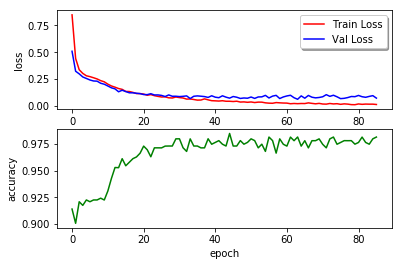

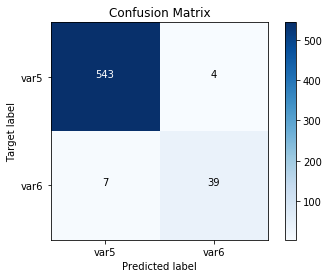

EPOCH: 87
TRAIN LOSS: 0.01155892869021544
VAL LOSS: 0.08981693767660891
VAL ACCURACY: 98.1 %
TIME: 12.3 s


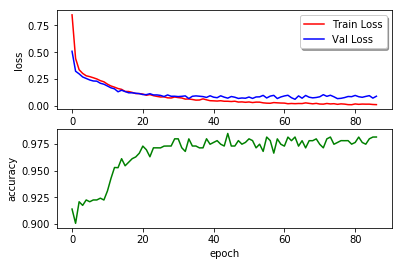

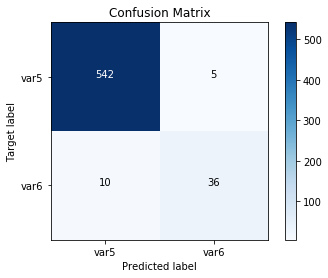

EPOCH: 88
TRAIN LOSS: 0.010358295250045075
VAL LOSS: 0.1010675758866837
VAL ACCURACY: 98.1 %
TIME: 12.7 s


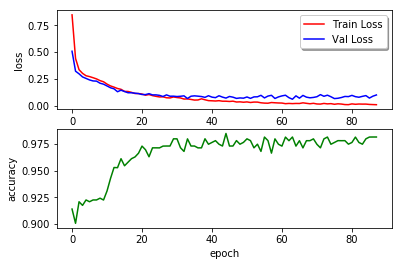

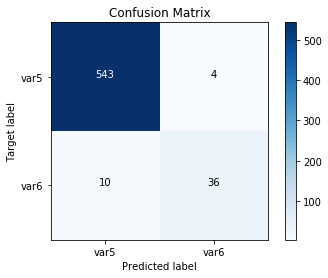

EPOCH: 89
TRAIN LOSS: 0.011422094961863383
VAL LOSS: 0.09392273715907085
VAL ACCURACY: 97.8 %
TIME: 12.4 s


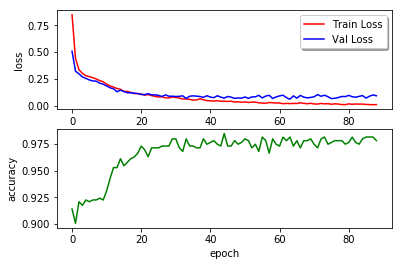

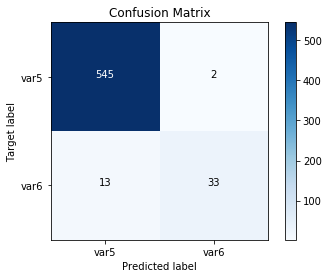

EPOCH: 90
TRAIN LOSS: 0.01301263488182814
VAL LOSS: 0.06424674859109814
VAL ACCURACY: 98.6 %
TIME: 12.9 s


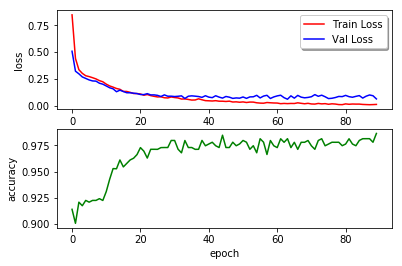

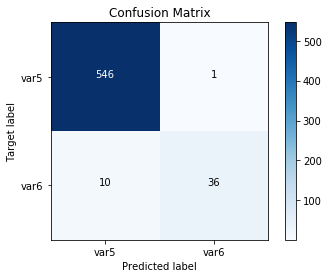

EPOCH: 91
TRAIN LOSS: 0.01158944123640563
VAL LOSS: 0.09767027292854322
VAL ACCURACY: 97.7 %
TIME: 13.3 s


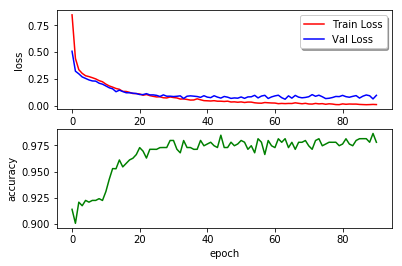

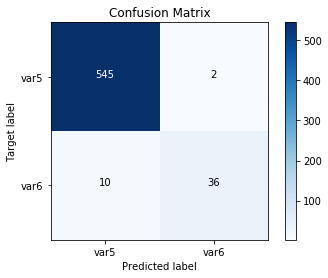

EPOCH: 92
TRAIN LOSS: 0.010439041920634527
VAL LOSS: 0.09897798960354293
VAL ACCURACY: 97.9 %
TIME: 12.6 s


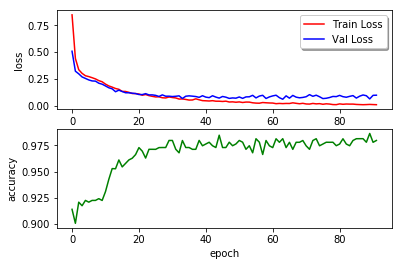

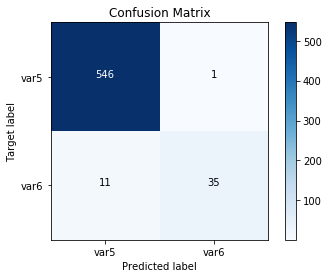

EPOCH: 93
TRAIN LOSS: 0.02241962688220749
VAL LOSS: 0.08419734272012411
VAL ACCURACY: 97.2 %
TIME: 12.8 s


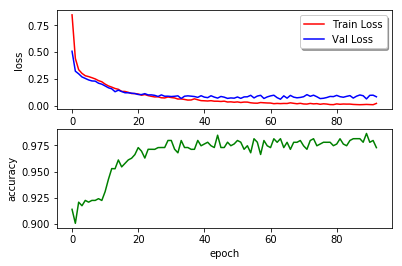

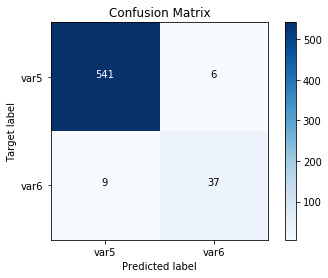

EPOCH: 94
TRAIN LOSS: 0.02086566614782563
VAL LOSS: 0.10436202925662069
VAL ACCURACY: 97.4 %
TIME: 11.4 s


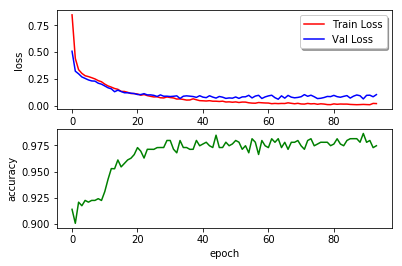

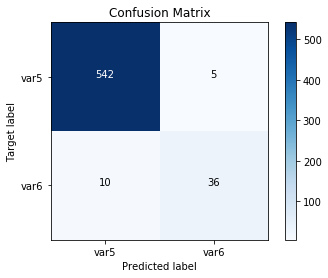

EPOCH: 95
TRAIN LOSS: 0.010246272170135127
VAL LOSS: 0.09107962138556244
VAL ACCURACY: 97.9 %
TIME: 13.0 s


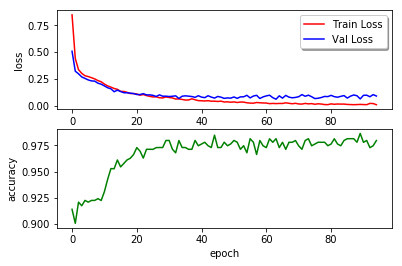

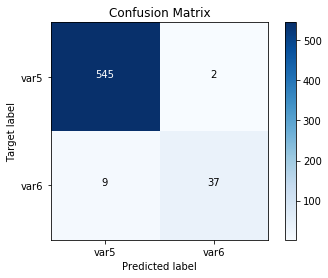

EPOCH: 96
TRAIN LOSS: 0.012985281421279922
VAL LOSS: 0.06555122641403838
VAL ACCURACY: 97.8 %
TIME: 12.0 s


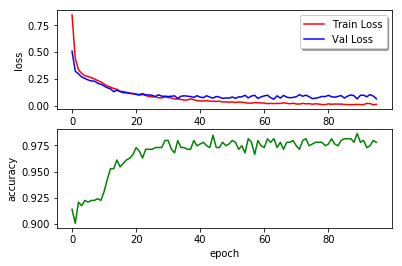

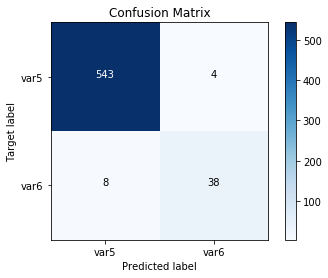

EPOCH: 97
TRAIN LOSS: 0.01415980599927987
VAL LOSS: 0.1256566567538726
VAL ACCURACY: 97.8 %
TIME: 13.4 s


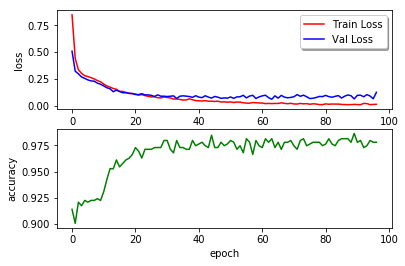

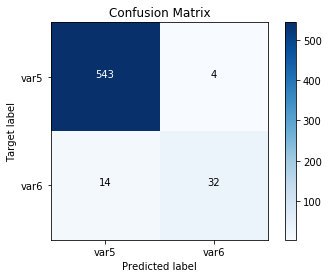

EPOCH: 98
TRAIN LOSS: 0.011786079742582166
VAL LOSS: 0.09102508110427895
VAL ACCURACY: 97.6 %
TIME: 12.4 s


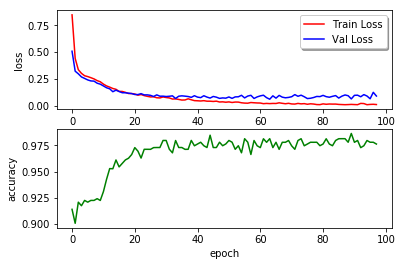

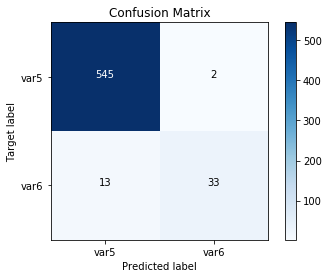

EPOCH: 99
TRAIN LOSS: 0.00878144820266422
VAL LOSS: 0.10607385312393647
VAL ACCURACY: 98.1 %
TIME: 13.4 s


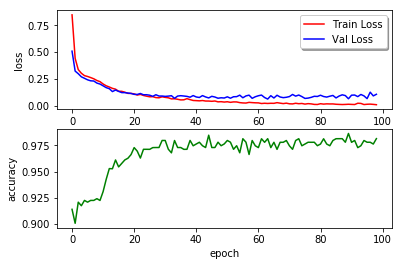

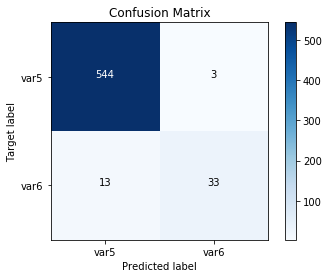

EPOCH: 100
TRAIN LOSS: 0.008713552302010675
VAL LOSS: 0.10449027355231091
VAL ACCURACY: 97.7 %
TIME: 12.6 s


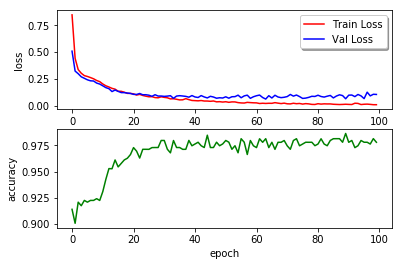

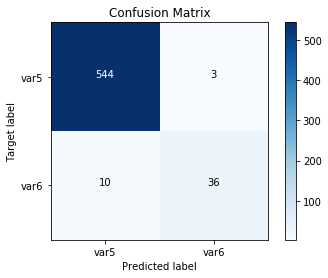

EPOCH: 101
TRAIN LOSS: 0.011356135962514065
VAL LOSS: 0.14943309882619765
VAL ACCURACY: 96.2 %
TIME: 12.6 s


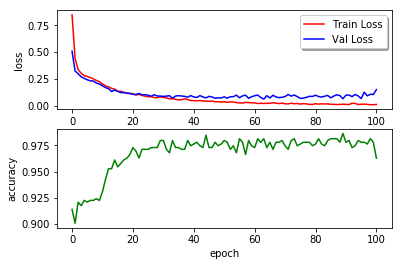

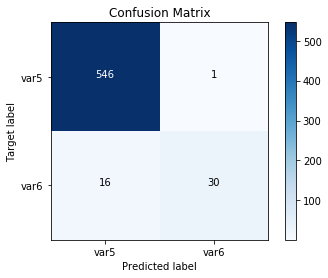

EPOCH: 102
TRAIN LOSS: 0.026358425030722773
VAL LOSS: 0.1360902733172134
VAL ACCURACY: 97.1 %
TIME: 12.8 s


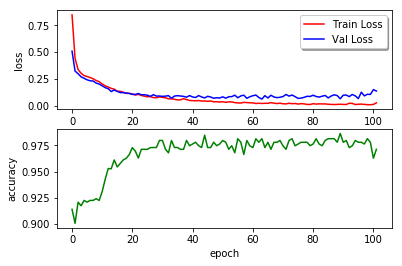

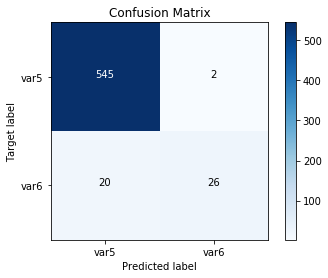

EPOCH: 103
TRAIN LOSS: 0.01903740811428134
VAL LOSS: 0.09687622765563358
VAL ACCURACY: 97.6 %
TIME: 12.9 s


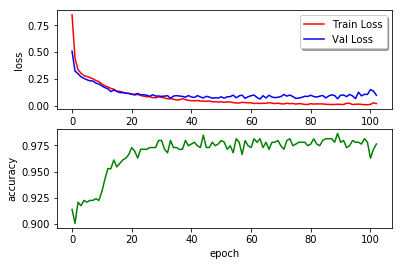

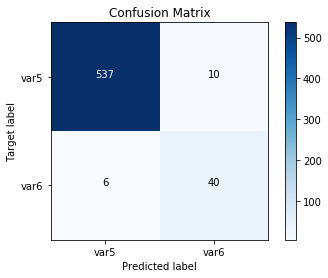

EPOCH: 104
TRAIN LOSS: 0.017287448519374138
VAL LOSS: 0.09562625701307613
VAL ACCURACY: 97.2 %
TIME: 13.5 s


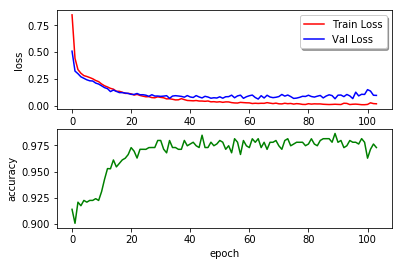

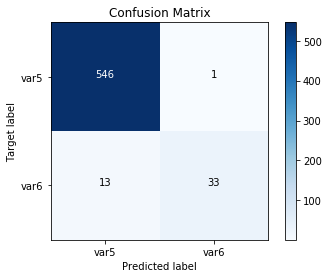

EPOCH: 105
TRAIN LOSS: 0.013661889885373986
VAL LOSS: 0.0960200860457461
VAL ACCURACY: 97.6 %
TIME: 12.3 s


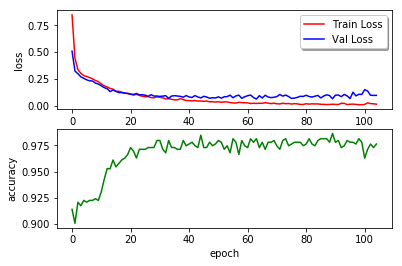

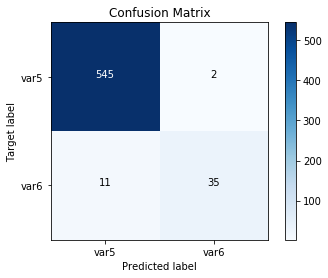

EPOCH: 106
TRAIN LOSS: 0.010825176557479544
VAL LOSS: 0.08155876130609087
VAL ACCURACY: 97.9 %
TIME: 13.1 s


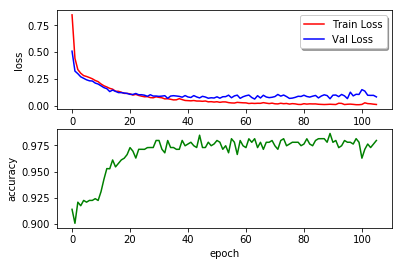

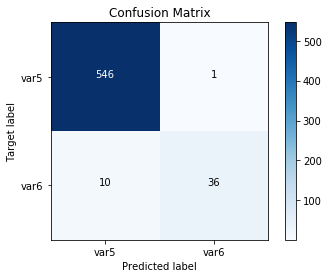

EPOCH: 107
TRAIN LOSS: 0.013262707773114106
VAL LOSS: 0.08446417885964569
VAL ACCURACY: 96.7 %
TIME: 12.4 s


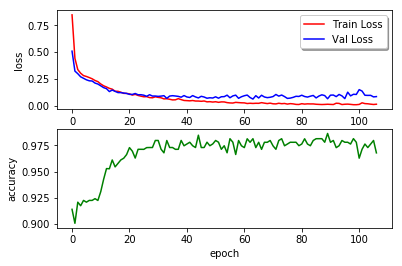

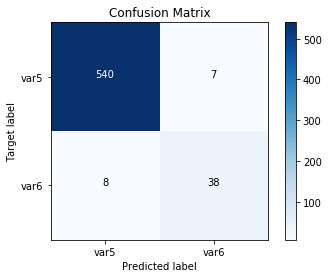

EPOCH: 108
TRAIN LOSS: 0.012203828606138133
VAL LOSS: 0.07896341675937615
VAL ACCURACY: 98.4 %
TIME: 12.3 s


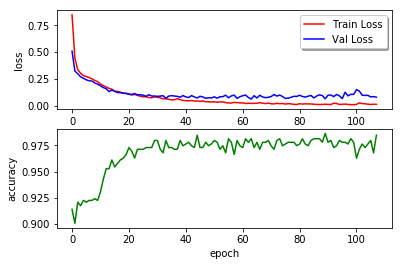

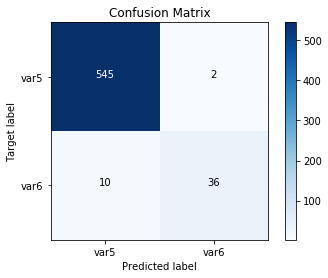

EPOCH: 109
TRAIN LOSS: 0.014277813793499409
VAL LOSS: 0.11179289441481124
VAL ACCURACY: 97.4 %
TIME: 12.6 s


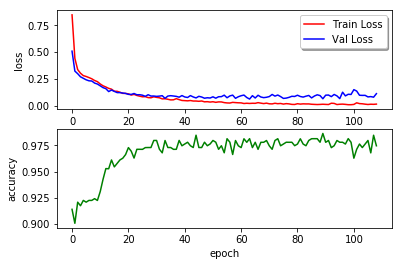

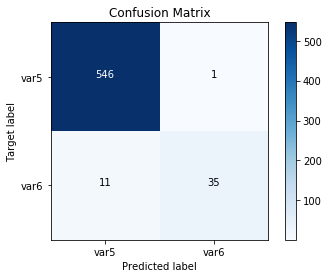

EPOCH: 110
TRAIN LOSS: 0.013071087800139287
VAL LOSS: 0.07715608458665493
VAL ACCURACY: 98.1 %
TIME: 12.5 s


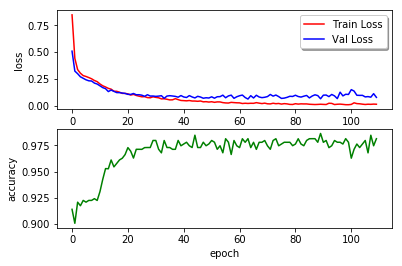

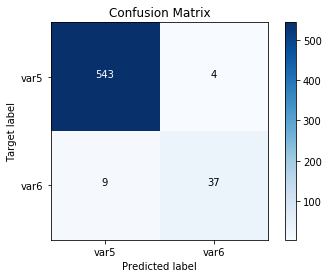

EPOCH: 111
TRAIN LOSS: 0.01025106080563614
VAL LOSS: 0.09648958615894357
VAL ACCURACY: 97.8 %
TIME: 12.6 s


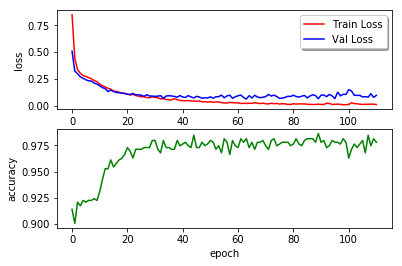

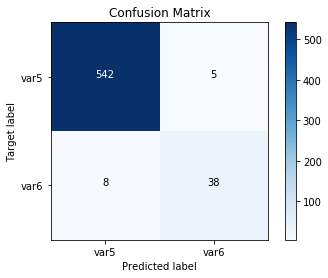

EPOCH: 112
TRAIN LOSS: 0.012149223811106998
VAL LOSS: 0.08907715066685166
VAL ACCURACY: 97.6 %
TIME: 13.0 s


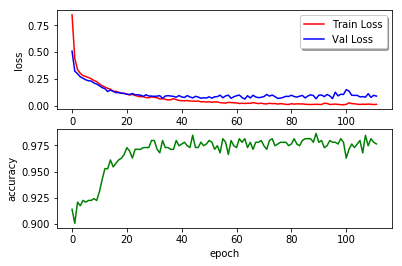

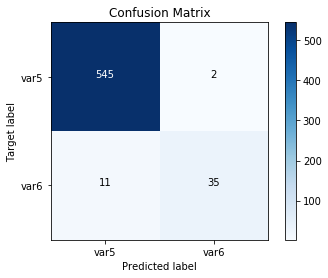

EPOCH: 113
TRAIN LOSS: 0.01144667226418439
VAL LOSS: 0.08945462719422892
VAL ACCURACY: 97.6 %
TIME: 12.9 s


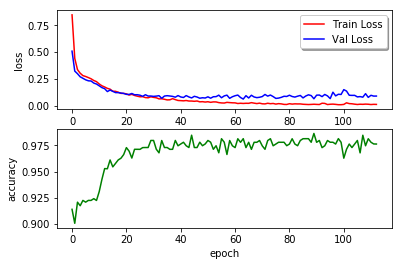

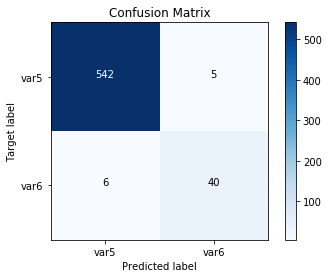

EPOCH: 114
TRAIN LOSS: 0.016306740258686878
VAL LOSS: 0.10161960407447437
VAL ACCURACY: 97.6 %
TIME: 13.2 s


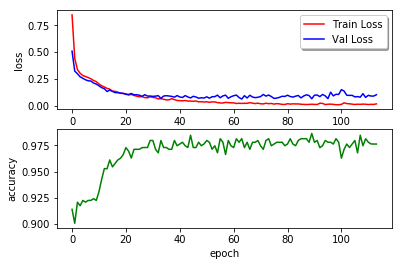

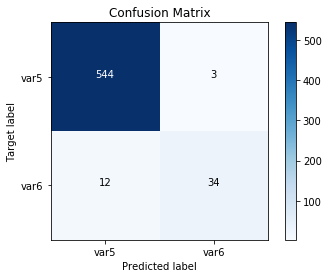

EPOCH: 115
TRAIN LOSS: 0.00872098877449801
VAL LOSS: 0.13173605245881387
VAL ACCURACY: 97.2 %
TIME: 11.8 s


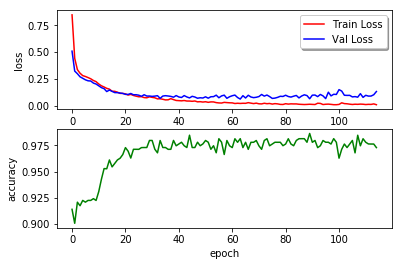

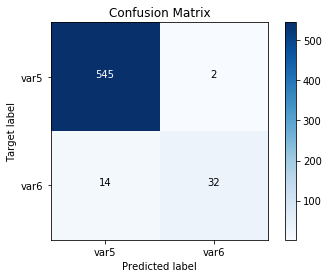

EPOCH: 116
TRAIN LOSS: 0.011849105805177207
VAL LOSS: 0.13048022667102332
VAL ACCURACY: 97.1 %
TIME: 13.7 s


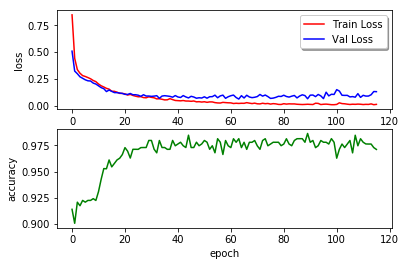

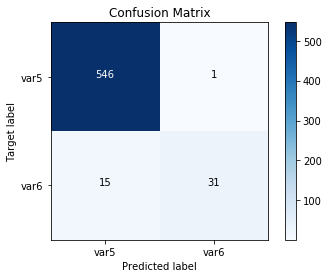

EPOCH: 117
TRAIN LOSS: 0.012709217077476659
VAL LOSS: 0.13183904756326673
VAL ACCURACY: 97.7 %
TIME: 12.5 s


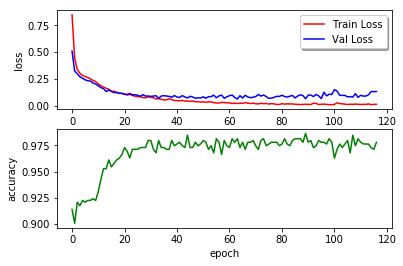

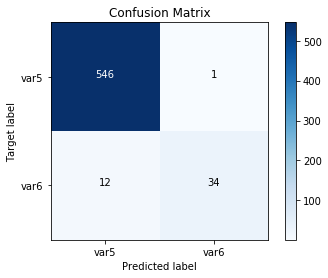

EPOCH: 118
TRAIN LOSS: 0.018371647048268294
VAL LOSS: 0.0926322839632795
VAL ACCURACY: 97.4 %
TIME: 12.8 s


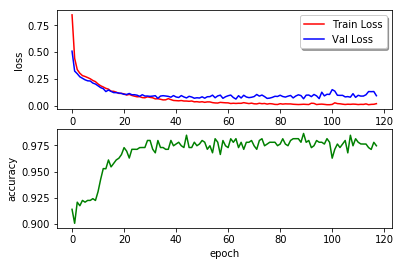

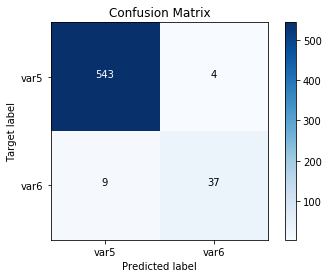

EPOCH: 119
TRAIN LOSS: 0.011550700806955414
VAL LOSS: 0.10006686702491258
VAL ACCURACY: 97.6 %
TIME: 12.2 s


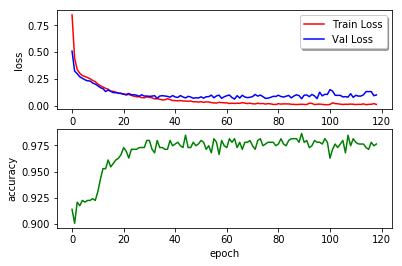

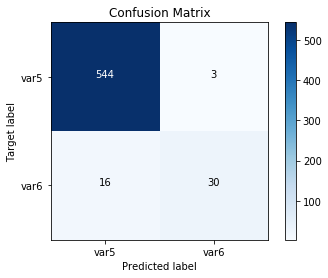

EPOCH: 120
TRAIN LOSS: 0.01473028384907224
VAL LOSS: 0.08500310281670351
VAL ACCURACY: 97.4 %
TIME: 12.4 s


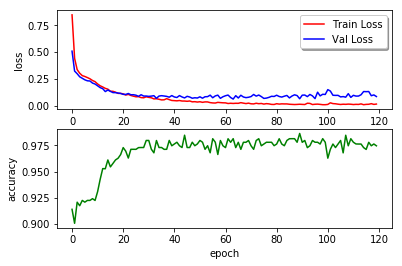

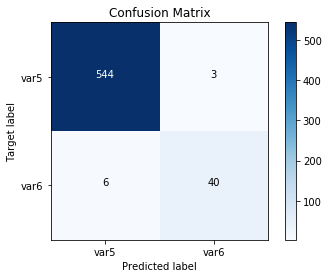

EPOCH: 121
TRAIN LOSS: 0.0160376759083635
VAL LOSS: 0.07568490179488079
VAL ACCURACY: 97.9 %
TIME: 12.9 s


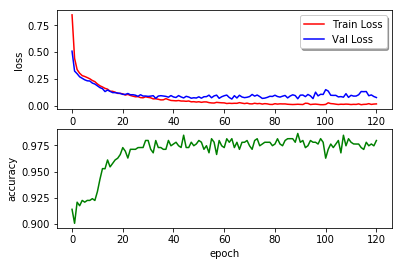

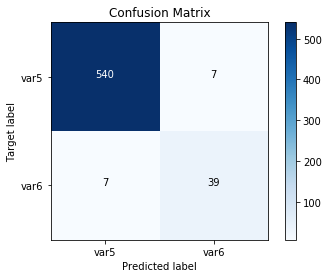

EPOCH: 122
TRAIN LOSS: 0.018472847465572206
VAL LOSS: 0.07500579478139369
VAL ACCURACY: 98.8 %
TIME: 14.9 s


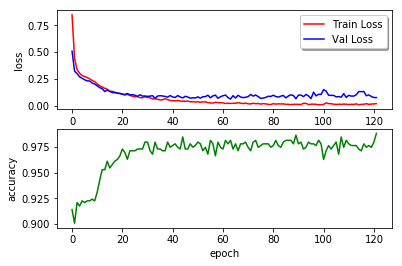

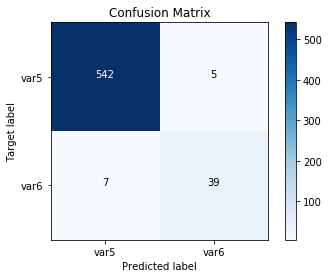

EPOCH: 123
TRAIN LOSS: 0.011652369152446915
VAL LOSS: 0.08425749830908097
VAL ACCURACY: 97.2 %
TIME: 13.0 s


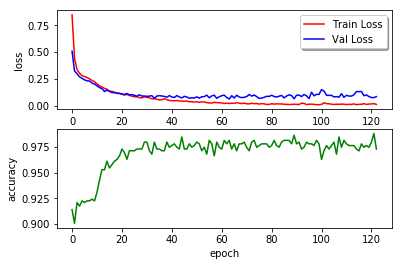

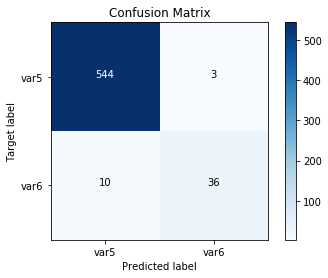

EPOCH: 124
TRAIN LOSS: 0.010026125562487517
VAL LOSS: 0.1090731417013564
VAL ACCURACY: 97.4 %
TIME: 11.7 s


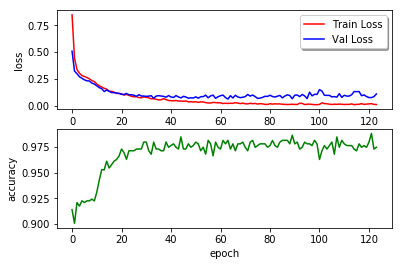

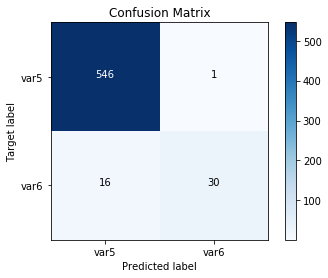

EPOCH: 125
TRAIN LOSS: 0.015114804428118078
VAL LOSS: 0.11770047889206076
VAL ACCURACY: 97.6 %
TIME: 13.5 s


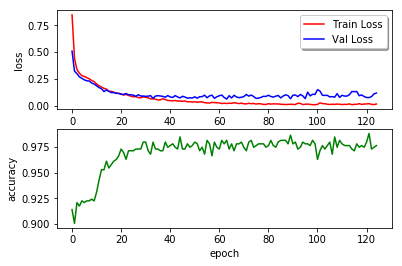

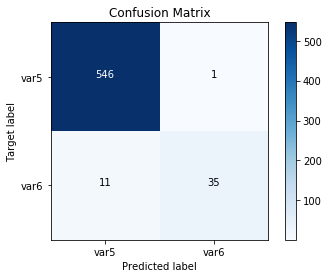

EPOCH: 126
TRAIN LOSS: 0.010667712583791292
VAL LOSS: 0.09688911854140628
VAL ACCURACY: 98.1 %
TIME: 12.2 s


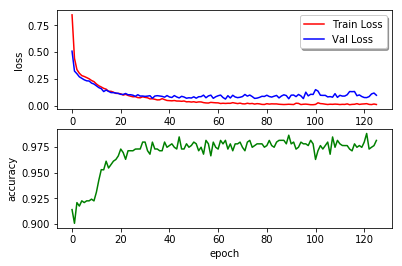

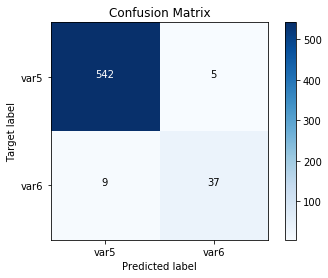

EPOCH: 127
TRAIN LOSS: 0.012002355794065155
VAL LOSS: 0.10112677188978815
VAL ACCURACY: 97.6 %
TIME: 13.0 s


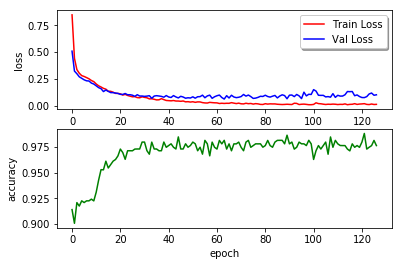

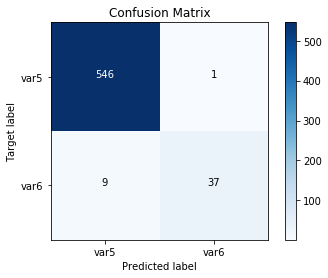

EPOCH: 128
TRAIN LOSS: 0.014562935739716064
VAL LOSS: 0.18286082477824644
VAL ACCURACY: 96.1 %
TIME: 11.2 s


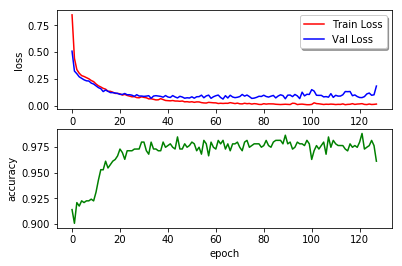

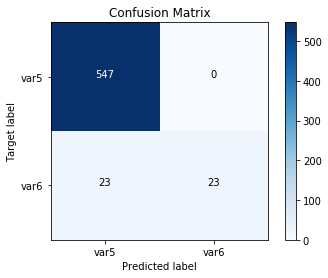

EPOCH: 129
TRAIN LOSS: 0.019861774744131824
VAL LOSS: 0.08582797478588139
VAL ACCURACY: 97.6 %
TIME: 13.2 s


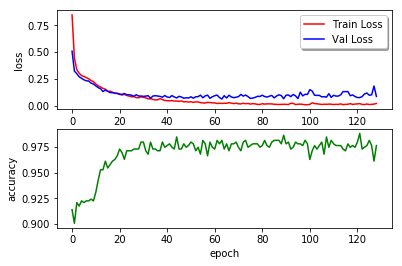

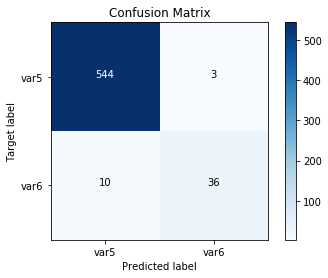

EPOCH: 130
TRAIN LOSS: 0.01115104413301173
VAL LOSS: 0.09807146466832092
VAL ACCURACY: 97.7 %
TIME: 12.1 s


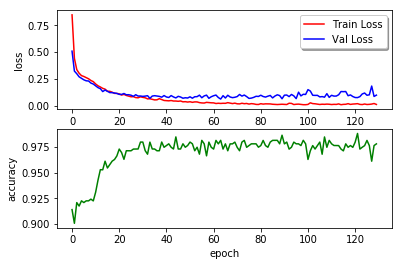

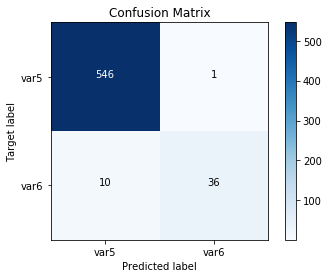

EPOCH: 131
TRAIN LOSS: 0.01361919326206781
VAL LOSS: 0.12875886036898831
VAL ACCURACY: 97.9 %
TIME: 12.7 s


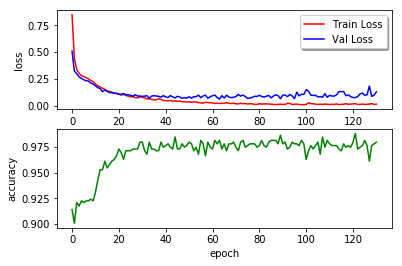

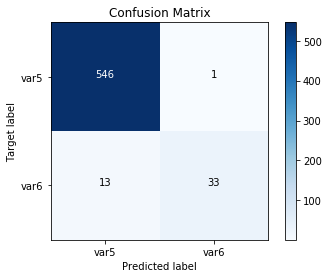

EPOCH: 132
TRAIN LOSS: 0.015393255366402101
VAL LOSS: 0.12738425399057368
VAL ACCURACY: 97.6 %
TIME: 12.5 s


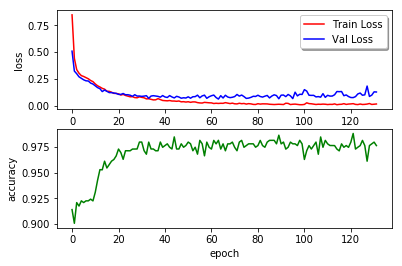

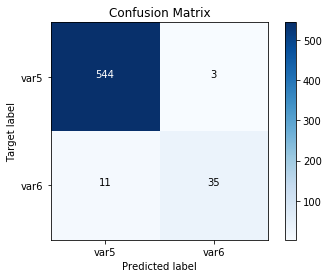

EPOCH: 133
TRAIN LOSS: 0.012419745201320647
VAL LOSS: 0.2202887421858583
VAL ACCURACY: 96.6 %
TIME: 12.8 s


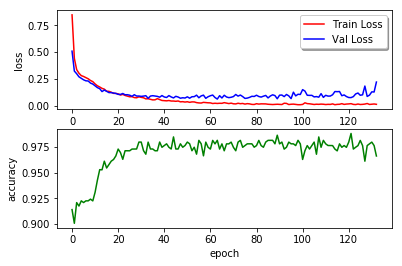

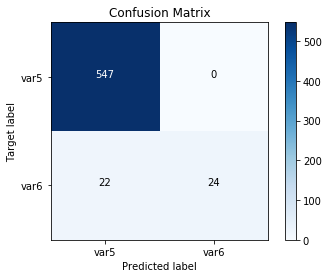

EPOCH: 134
TRAIN LOSS: 0.025542551957547757
VAL LOSS: 0.1286224921235184
VAL ACCURACY: 96.6 %
TIME: 12.0 s


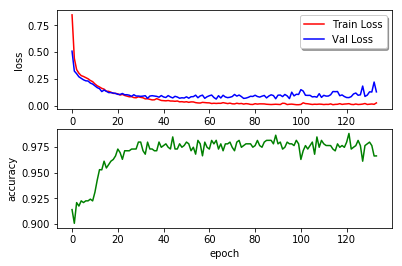

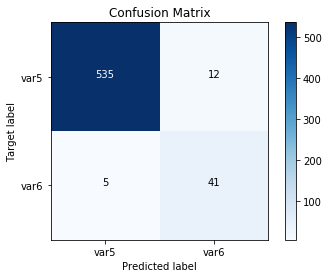

EPOCH: 135
TRAIN LOSS: 0.1271356001736117
VAL LOSS: 0.377281365387786
VAL ACCURACY: 94.7 %
TIME: 12.5 s


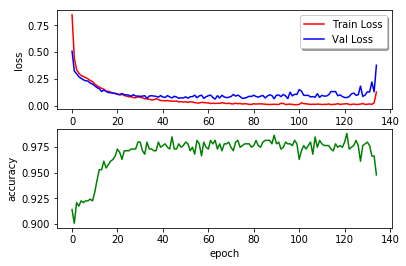

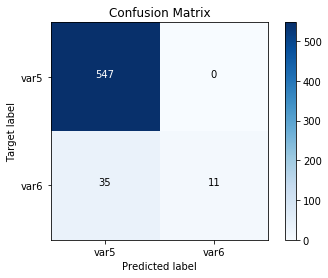

EPOCH: 136
TRAIN LOSS: 0.08170660537263916
VAL LOSS: 0.11406108309820995
VAL ACCURACY: 97.4 %
TIME: 12.4 s


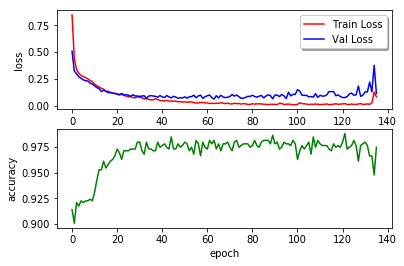

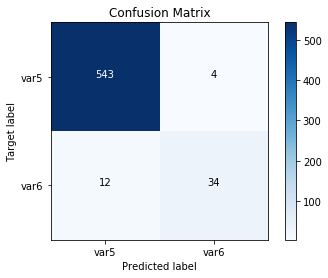

EPOCH: 137
TRAIN LOSS: 0.03621208957064235
VAL LOSS: 0.08362934657893135
VAL ACCURACY: 97.1 %
TIME: 12.6 s


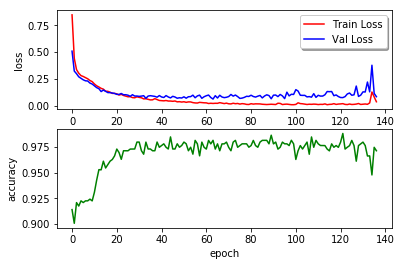

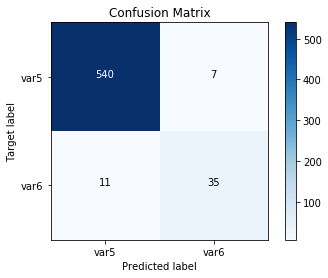

EPOCH: 138
TRAIN LOSS: 0.03299268702941864
VAL LOSS: 0.09415174538410855
VAL ACCURACY: 97.1 %
TIME: 13.7 s


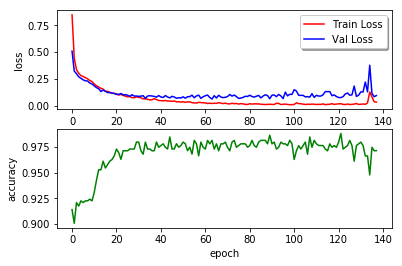

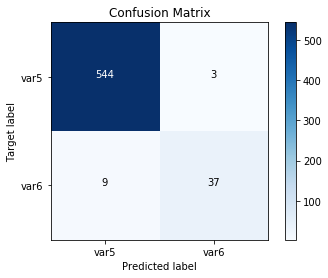

EPOCH: 139
TRAIN LOSS: 0.030985492391027034
VAL LOSS: 0.07208061724968386
VAL ACCURACY: 98.3 %
TIME: 13.1 s


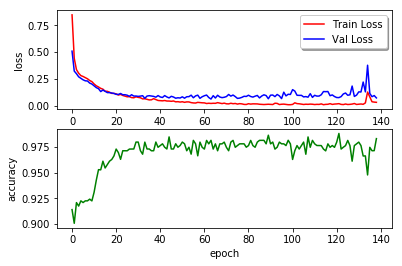

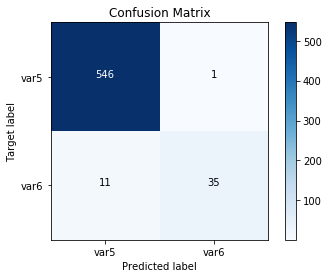

EPOCH: 140
TRAIN LOSS: 0.03337343244006437
VAL LOSS: 0.06670627312032257
VAL ACCURACY: 97.4 %
TIME: 13.0 s


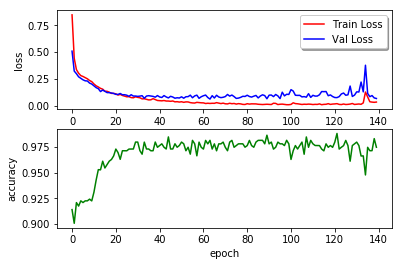

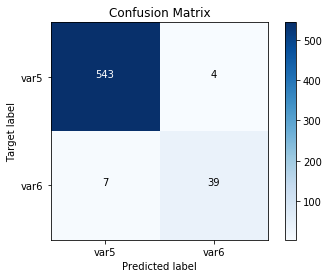

EPOCH: 141
TRAIN LOSS: 0.02942216002721436
VAL LOSS: 0.07398926879082711
VAL ACCURACY: 97.4 %
TIME: 12.8 s


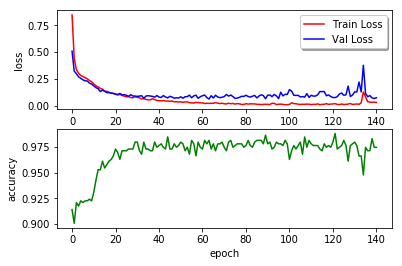

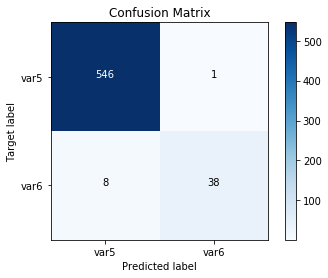

EPOCH: 142
TRAIN LOSS: 0.02891471792502202
VAL LOSS: 0.07675001453415017
VAL ACCURACY: 97.1 %
TIME: 12.8 s


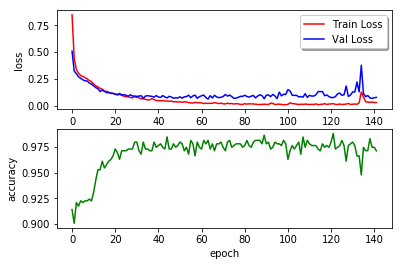

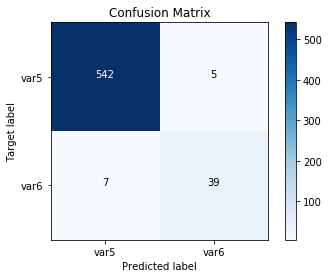

EPOCH: 143
TRAIN LOSS: 0.025562039707601424
VAL LOSS: 0.07758280282789229
VAL ACCURACY: 97.2 %
TIME: 11.9 s


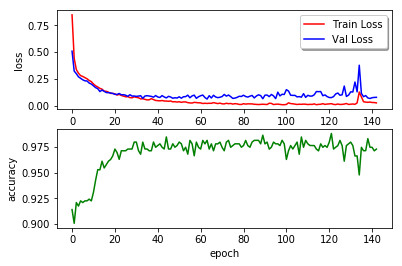

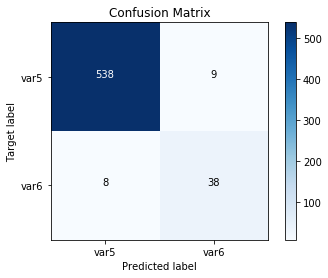

EPOCH: 144
TRAIN LOSS: 0.03133797364136898
VAL LOSS: 0.08101598763634735
VAL ACCURACY: 97.4 %
TIME: 12.4 s


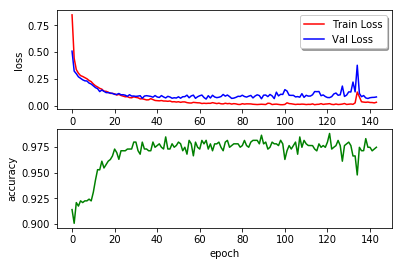

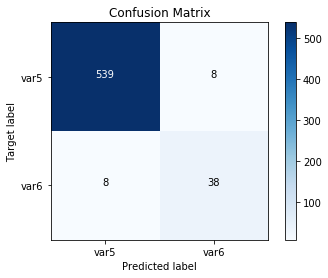

EPOCH: 145
TRAIN LOSS: 0.02757776367279676
VAL LOSS: 0.07789065266163005
VAL ACCURACY: 98.1 %
TIME: 11.7 s


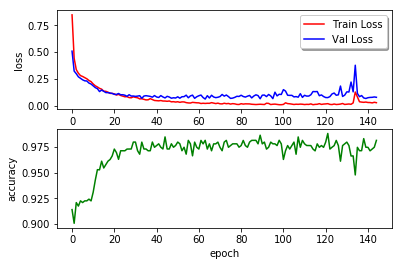

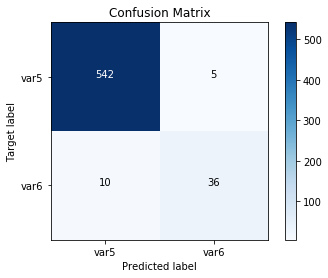

EPOCH: 146
TRAIN LOSS: 0.02586497327696115
VAL LOSS: 0.07461178688973807
VAL ACCURACY: 97.6 %
TIME: 12.6 s


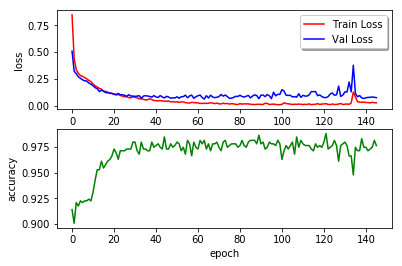

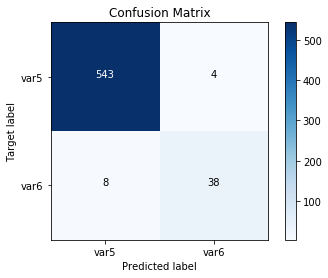

EPOCH: 147
TRAIN LOSS: 0.02218493215757724
VAL LOSS: 0.07987005556211464
VAL ACCURACY: 97.4 %
TIME: 12.8 s


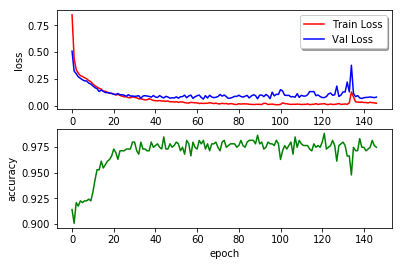

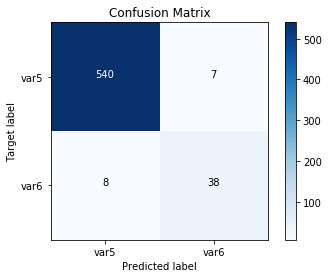

EPOCH: 148
TRAIN LOSS: 0.02094369657592255
VAL LOSS: 0.04914664555407752
VAL ACCURACY: 97.7 %
TIME: 13.9 s


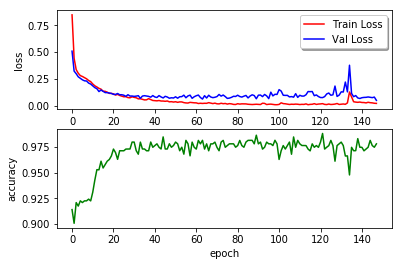

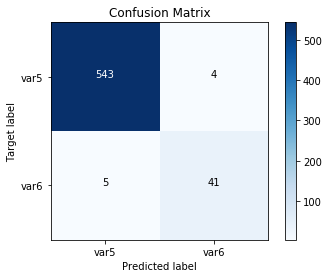

EPOCH: 149
TRAIN LOSS: 0.019398054823590978
VAL LOSS: 0.0840242722013644
VAL ACCURACY: 97.1 %
TIME: 12.7 s


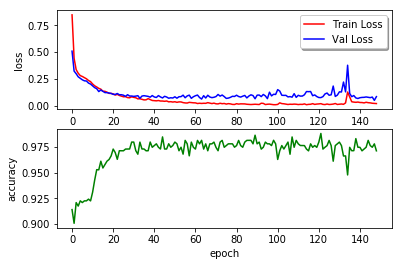

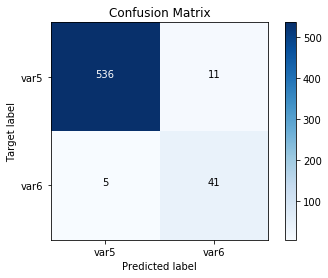

EPOCH: 150
TRAIN LOSS: 0.020336186042903284
VAL LOSS: 0.07761038945023938
VAL ACCURACY: 97.9 %
TIME: 14.0 s


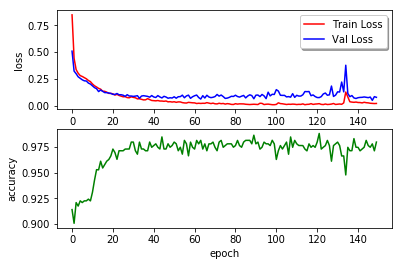

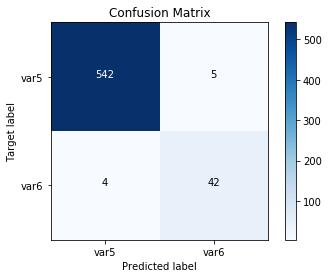

EPOCH: 151
TRAIN LOSS: 0.022496237120079924
VAL LOSS: 0.0806874238112398
VAL ACCURACY: 97.9 %
TIME: 13.1 s


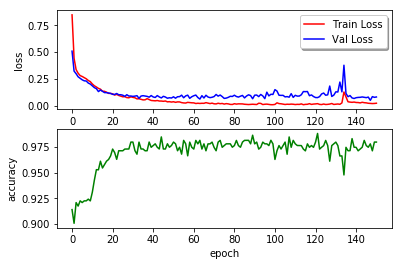

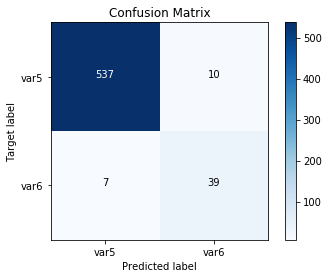

EPOCH: 152
TRAIN LOSS: 0.02608232500385045
VAL LOSS: 0.09818708014090233
VAL ACCURACY: 97.4 %
TIME: 12.9 s


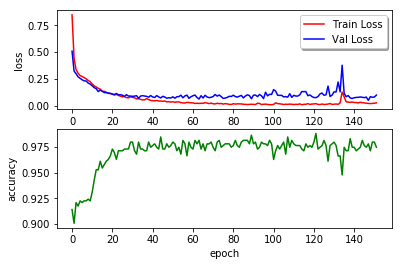

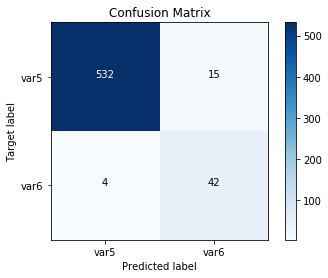

EPOCH: 153
TRAIN LOSS: 0.035537260005630025
VAL LOSS: 0.07474629102943707
VAL ACCURACY: 97.9 %
TIME: 12.6 s


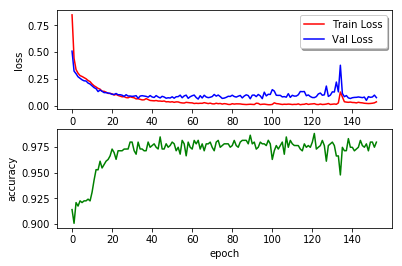

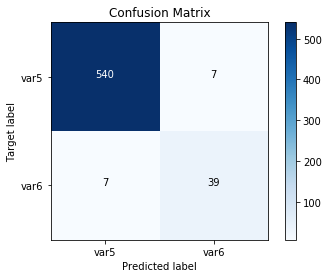

EPOCH: 154
TRAIN LOSS: 0.022240176424463208
VAL LOSS: 0.08174982486083324
VAL ACCURACY: 97.6 %
TIME: 12.8 s


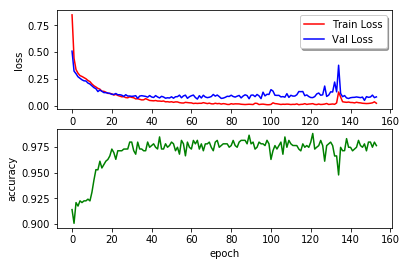

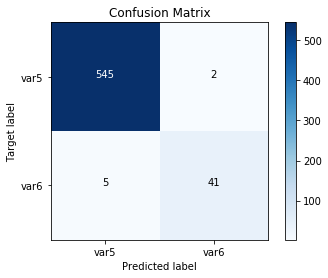

EPOCH: 155
TRAIN LOSS: 0.02297898754380412
VAL LOSS: 0.0886006778424206
VAL ACCURACY: 97.6 %
TIME: 14.3 s


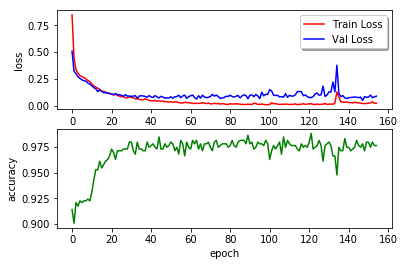

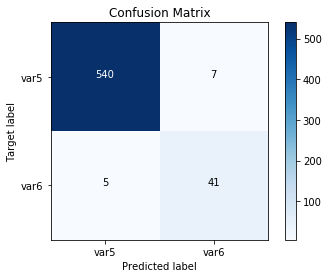

EPOCH: 156
TRAIN LOSS: 0.020472036900991815
VAL LOSS: 0.09275916316952322
VAL ACCURACY: 96.9 %
TIME: 11.9 s


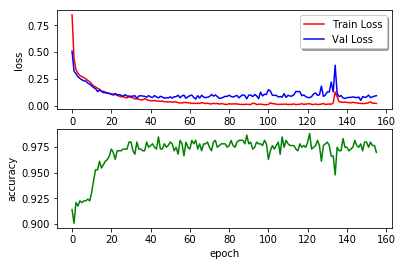

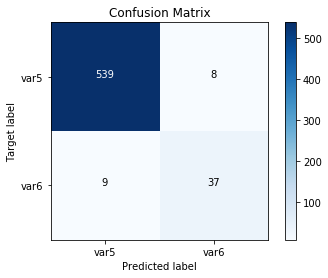

EPOCH: 157
TRAIN LOSS: 0.01923610929450749
VAL LOSS: 0.1063623626692474
VAL ACCURACY: 96.9 %
TIME: 13.5 s


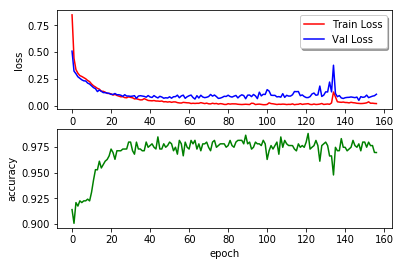

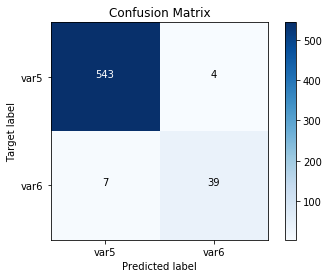

EPOCH: 158
TRAIN LOSS: 0.013909130338622785
VAL LOSS: 0.09135701187423162
VAL ACCURACY: 97.6 %
TIME: 12.2 s


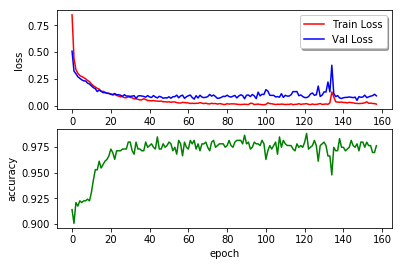

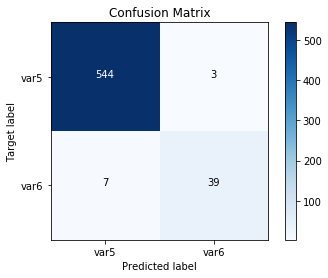

EPOCH: 159
TRAIN LOSS: 0.014970406047298126
VAL LOSS: 0.07919079373991027
VAL ACCURACY: 98.1 %
TIME: 13.6 s


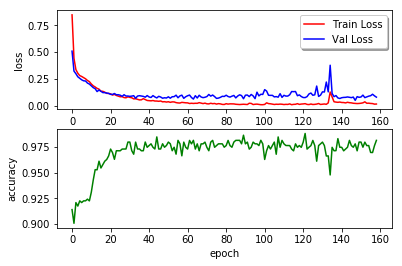

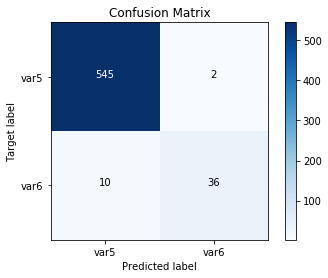

EPOCH: 160
TRAIN LOSS: 0.016151338063048144
VAL LOSS: 0.06456061535664909
VAL ACCURACY: 98.1 %
TIME: 13.0 s


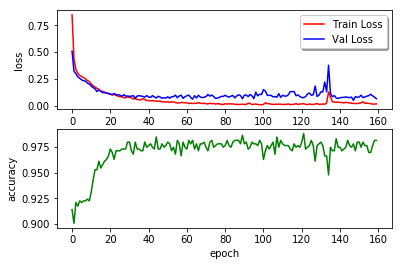

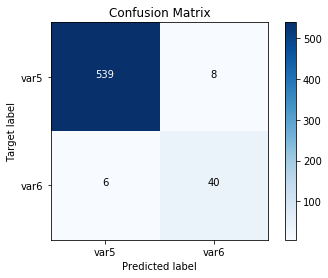

EPOCH: 161
TRAIN LOSS: 0.015379826540385527
VAL LOSS: 0.07137126980490997
VAL ACCURACY: 97.8 %
TIME: 12.9 s


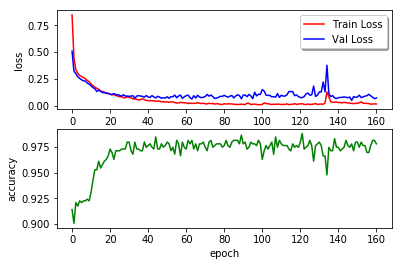

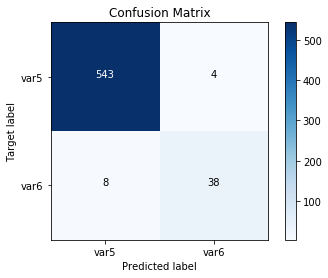

EPOCH: 162
TRAIN LOSS: 0.015472905438202848
VAL LOSS: 0.08889437378448636
VAL ACCURACY: 97.2 %
TIME: 13.2 s


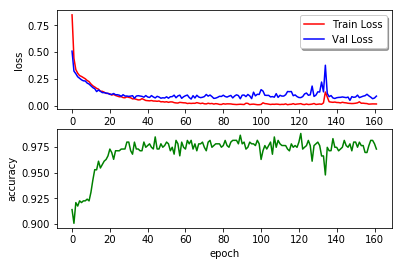

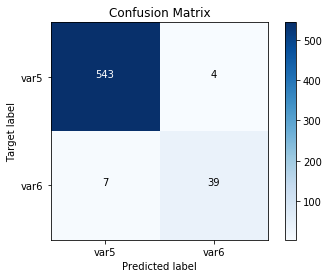

EPOCH: 163
TRAIN LOSS: 0.012587545254537716
VAL LOSS: 0.1009854802358845
VAL ACCURACY: 98.1 %
TIME: 13.1 s


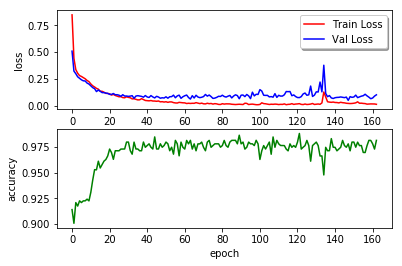

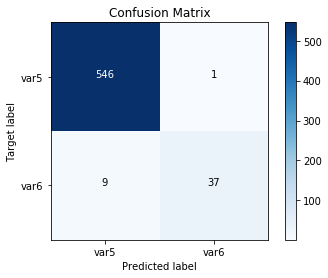

EPOCH: 164
TRAIN LOSS: 0.012106372894715325
VAL LOSS: 0.10165184934794155
VAL ACCURACY: 98.1 %
TIME: 12.1 s


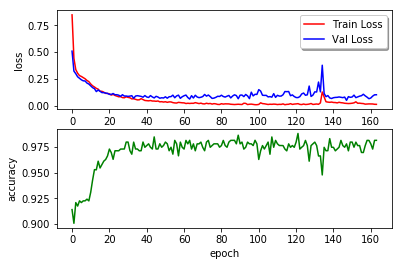

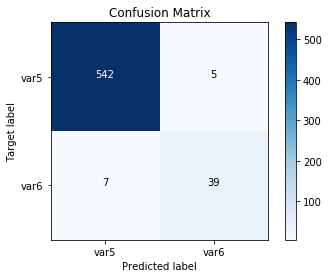

EPOCH: 165
TRAIN LOSS: 0.014609007851265864
VAL LOSS: 0.0829867794056189
VAL ACCURACY: 97.4 %
TIME: 13.1 s


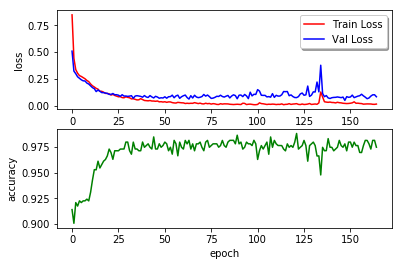

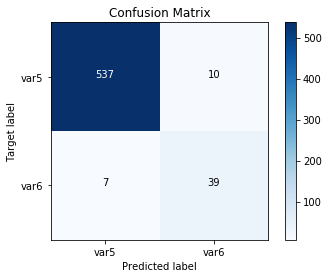

EPOCH: 166
TRAIN LOSS: 0.016788972931007885
VAL LOSS: 0.07931811464253141
VAL ACCURACY: 97.8 %
TIME: 12.4 s


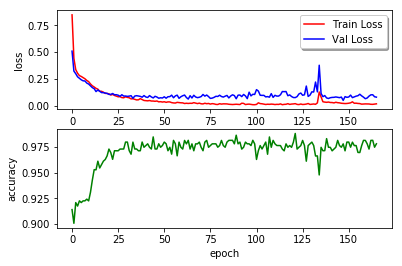

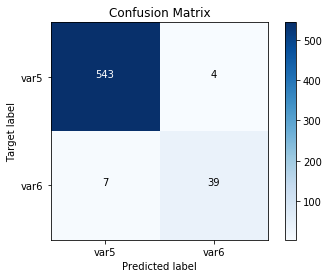

EPOCH: 167
TRAIN LOSS: 0.01467885485718617
VAL LOSS: 0.08796652430706378
VAL ACCURACY: 97.9 %
TIME: 13.3 s


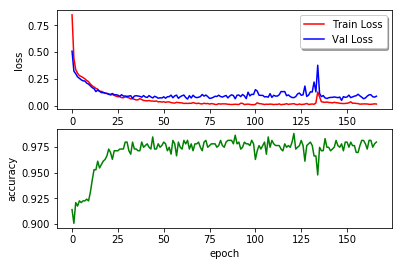

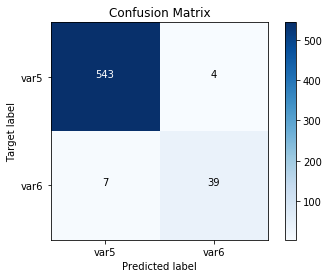

EPOCH: 168
TRAIN LOSS: 0.014400684512742675
VAL LOSS: 0.1019172292349105
VAL ACCURACY: 97.6 %
TIME: 13.1 s


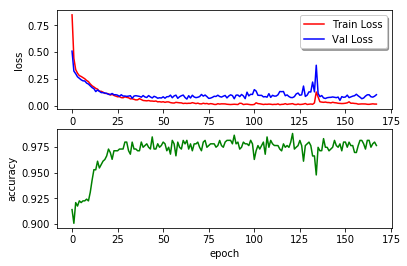

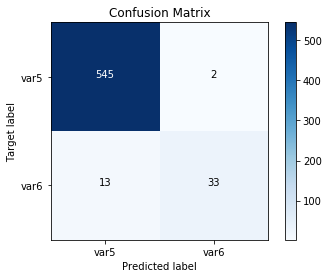

EPOCH: 169
TRAIN LOSS: 0.012007298684927553
VAL LOSS: 0.06998074780442144
VAL ACCURACY: 97.9 %
TIME: 13.4 s


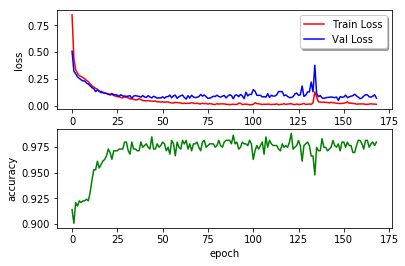

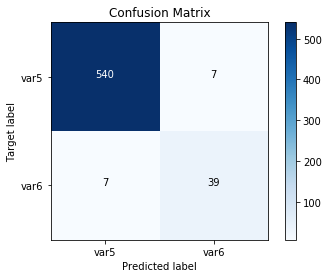

EPOCH: 170
TRAIN LOSS: 0.011803286056696735
VAL LOSS: 0.10019469695736617
VAL ACCURACY: 97.6 %
TIME: 13.5 s


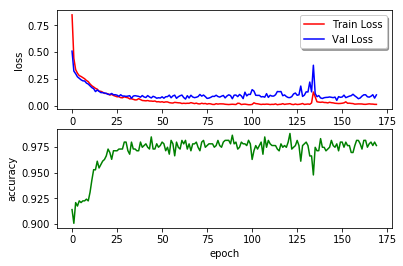

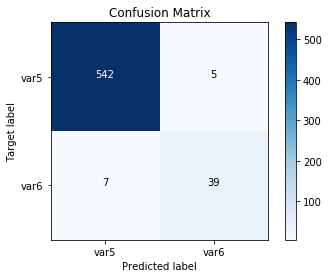

EPOCH: 171
TRAIN LOSS: 0.012860036982784886
VAL LOSS: 0.12351635680849724
VAL ACCURACY: 97.4 %
TIME: 13.1 s


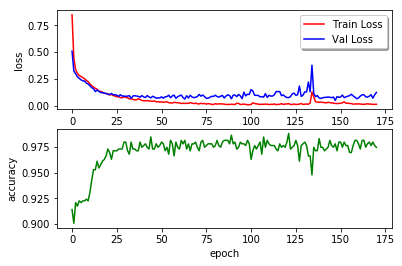

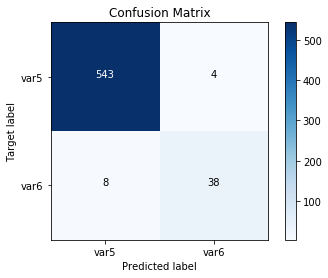

EPOCH: 172
TRAIN LOSS: 0.014100763970753504
VAL LOSS: 0.1041958824476007
VAL ACCURACY: 97.9 %
TIME: 13.3 s


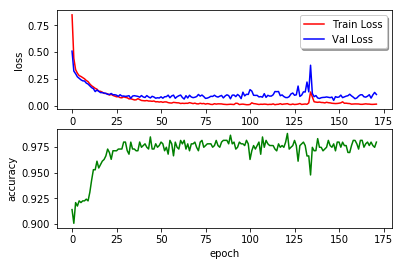

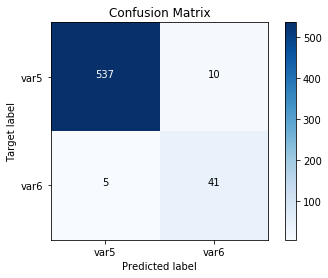

EPOCH: 173
TRAIN LOSS: 0.013401842530247527
VAL LOSS: 0.07976421684605559
VAL ACCURACY: 98.1 %
TIME: 11.9 s


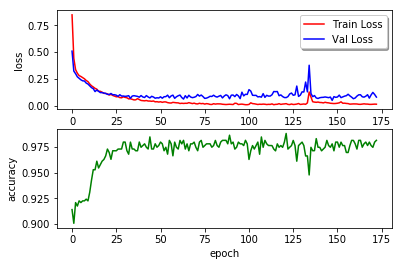

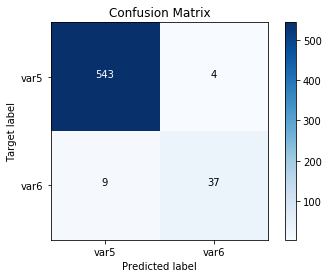

EPOCH: 174
TRAIN LOSS: 0.014179310002942662
VAL LOSS: 0.09361381185431444
VAL ACCURACY: 98.3 %
TIME: 12.7 s


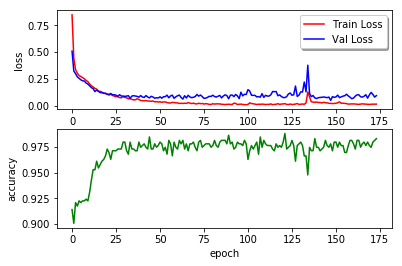

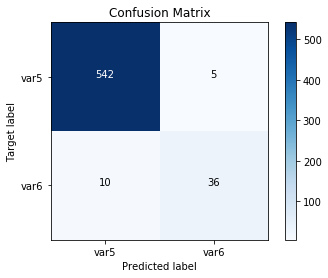

EPOCH: 175
TRAIN LOSS: 0.011857369478296256
VAL LOSS: 0.08935846384213192
VAL ACCURACY: 97.9 %
TIME: 12.5 s


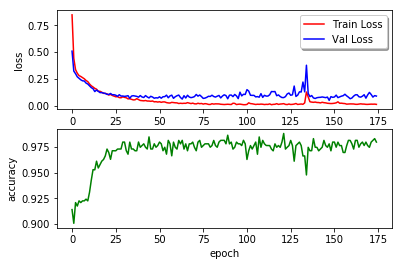

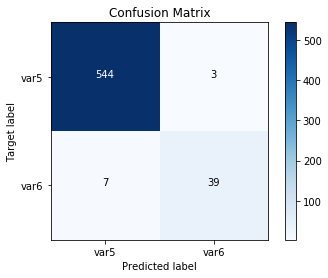

EPOCH: 176
TRAIN LOSS: 0.013176154919451828
VAL LOSS: 0.09658946216302496
VAL ACCURACY: 97.9 %
TIME: 14.1 s


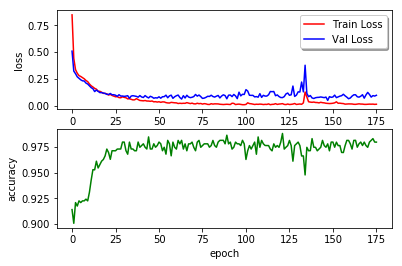

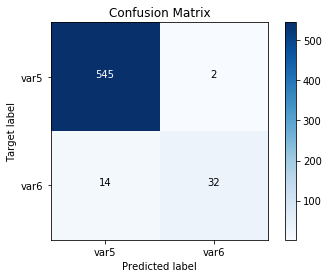

EPOCH: 177
TRAIN LOSS: 0.013268049005707182
VAL LOSS: 0.09700286776380701
VAL ACCURACY: 97.2 %
TIME: 12.8 s


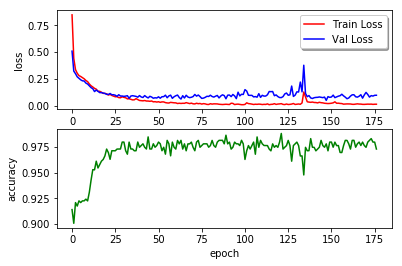

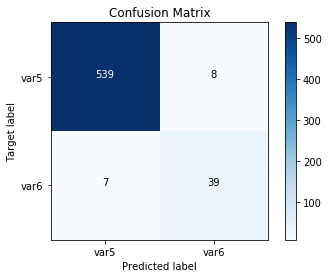

EPOCH: 178
TRAIN LOSS: 0.013082102521300112
VAL LOSS: 0.10738352925142103
VAL ACCURACY: 97.8 %
TIME: 13.4 s


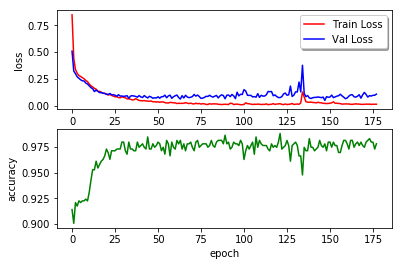

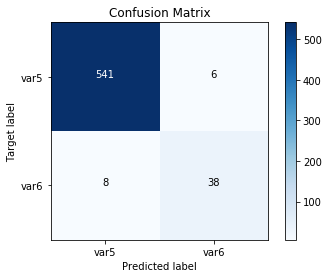

EPOCH: 179
TRAIN LOSS: 0.014574533914633762
VAL LOSS: 0.07674786004776482
VAL ACCURACY: 98.1 %
TIME: 12.8 s


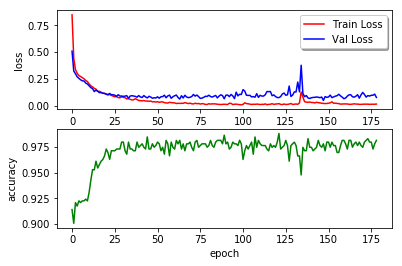

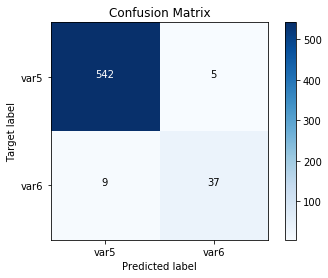

EPOCH: 180
TRAIN LOSS: 0.01216512299182828
VAL LOSS: 0.08084451052204591
VAL ACCURACY: 97.6 %
TIME: 14.1 s


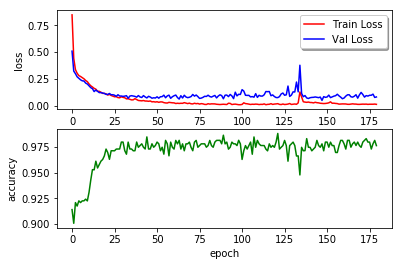

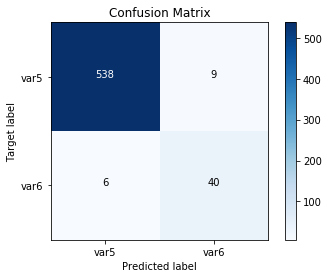

EPOCH: 181
TRAIN LOSS: 0.011471897848629576
VAL LOSS: 0.12634879059569665
VAL ACCURACY: 97.9 %
TIME: 14.0 s


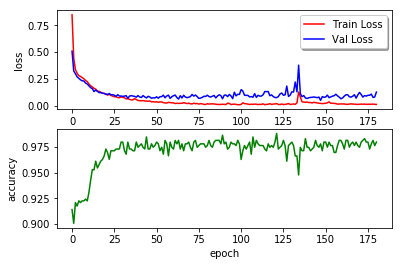

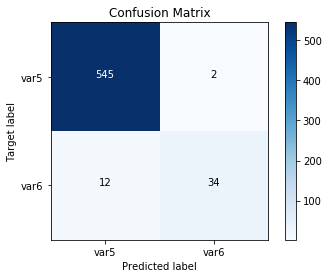

EPOCH: 182
TRAIN LOSS: 0.01040992691180564
VAL LOSS: 0.11570796363618412
VAL ACCURACY: 97.2 %
TIME: 12.7 s


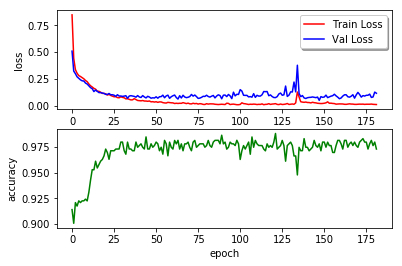

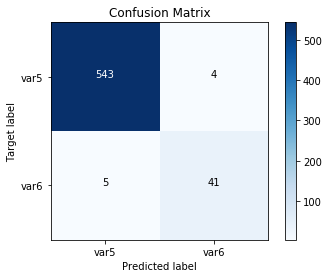

EPOCH: 183
TRAIN LOSS: 0.010620956318642705
VAL LOSS: 0.09238468758754036
VAL ACCURACY: 97.9 %
TIME: 12.6 s


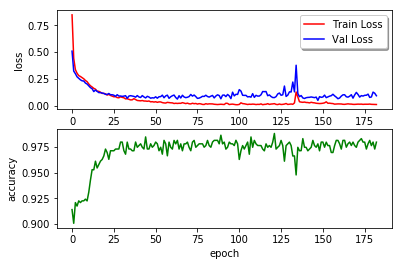

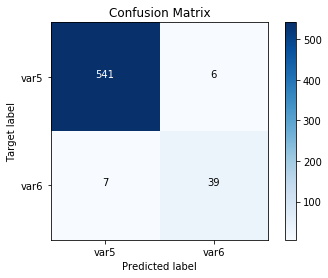

EPOCH: 184
TRAIN LOSS: 0.008205085918579283
VAL LOSS: 0.08855274559892189
VAL ACCURACY: 98.1 %
TIME: 12.7 s


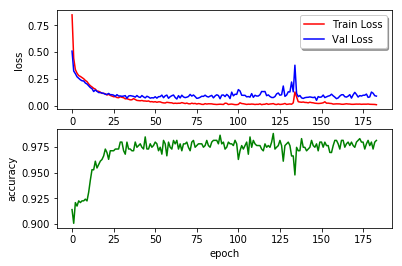

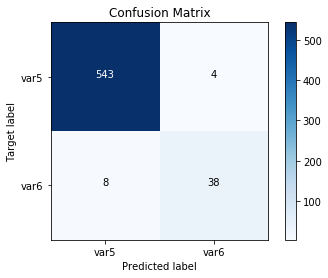

EPOCH: 185
TRAIN LOSS: 0.011430781553188898
VAL LOSS: 0.10527889652647562
VAL ACCURACY: 97.4 %
TIME: 11.9 s


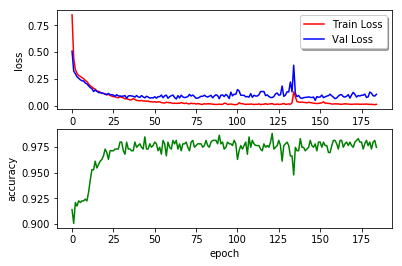

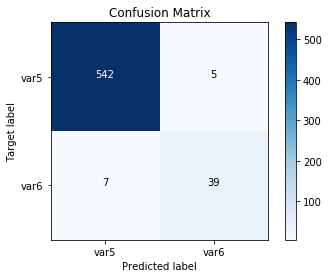

EPOCH: 186
TRAIN LOSS: 0.011859974172690671
VAL LOSS: 0.10825170884566056
VAL ACCURACY: 98.3 %
TIME: 13.5 s


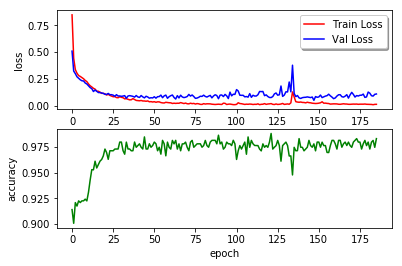

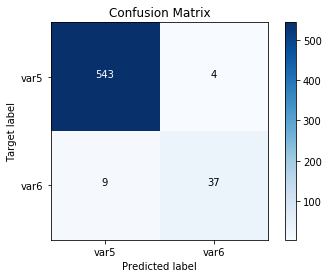

EPOCH: 187
TRAIN LOSS: 0.010976041319891622
VAL LOSS: 0.12189500416238094
VAL ACCURACY: 97.1 %
TIME: 13.0 s


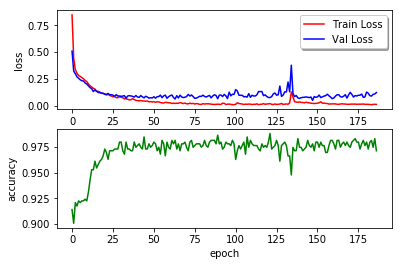

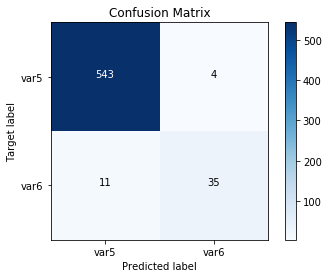

EPOCH: 188
TRAIN LOSS: 0.009139552520626294
VAL LOSS: 0.08662307569238269
VAL ACCURACY: 98.3 %
TIME: 13.5 s


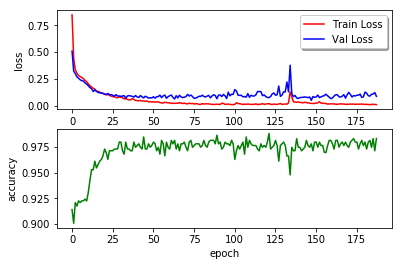

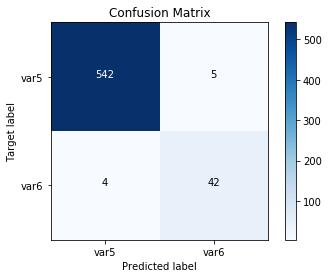

EPOCH: 189
TRAIN LOSS: 0.010591302357073314
VAL LOSS: 0.10618378362437764
VAL ACCURACY: 97.7 %
TIME: 13.3 s


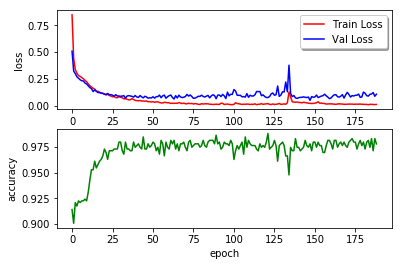

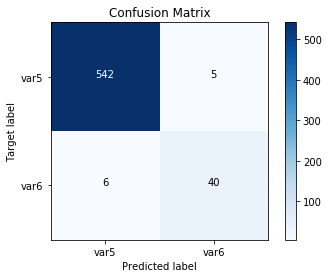

EPOCH: 190
TRAIN LOSS: 0.01010888004325048
VAL LOSS: 0.08633112016550304
VAL ACCURACY: 97.8 %
TIME: 12.4 s


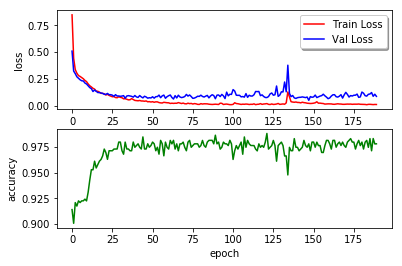

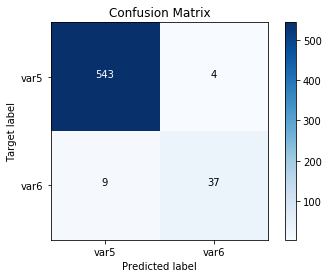

EPOCH: 191
TRAIN LOSS: 0.011617220874261019
VAL LOSS: 0.0993417660723064
VAL ACCURACY: 98.3 %
TIME: 13.7 s


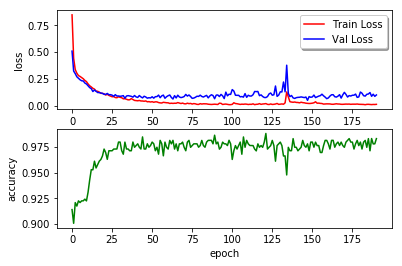

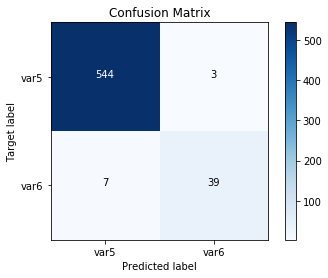

EPOCH: 192
TRAIN LOSS: 0.014919344432269383
VAL LOSS: 0.059391483344147615
VAL ACCURACY: 98.1 %
TIME: 13.2 s


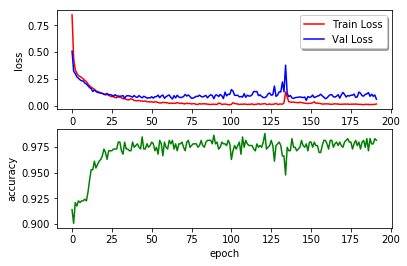

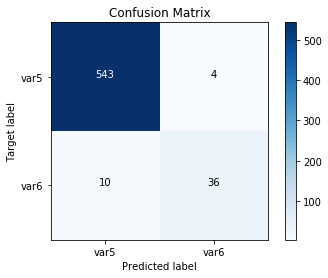

EPOCH: 193
TRAIN LOSS: 0.012746240279302238
VAL LOSS: 0.07737644954410987
VAL ACCURACY: 98.3 %
TIME: 13.4 s


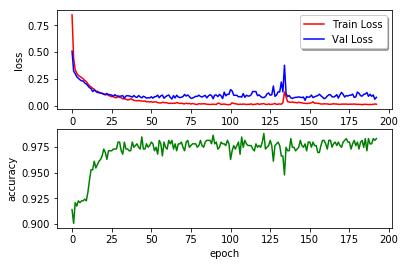

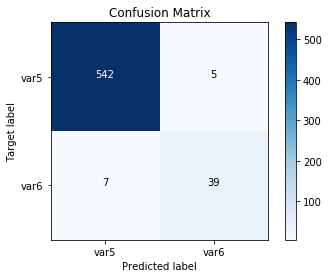

EPOCH: 194
TRAIN LOSS: 0.012807094910824775
VAL LOSS: 0.08818548622931424
VAL ACCURACY: 97.9 %
TIME: 12.7 s


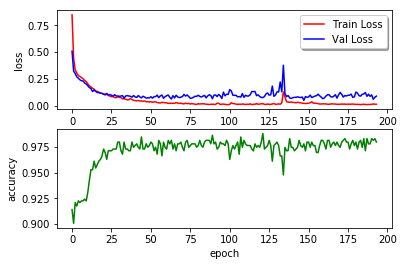

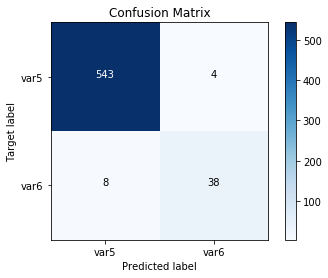

EPOCH: 195
TRAIN LOSS: 0.011549564838508539
VAL LOSS: 0.09054810709820495
VAL ACCURACY: 98.4 %
TIME: 12.9 s


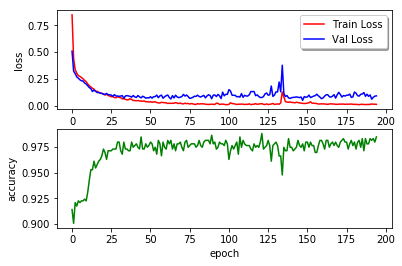

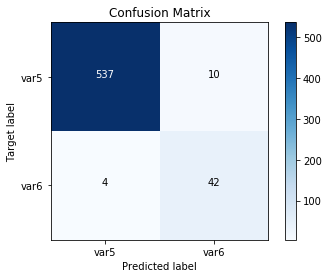

EPOCH: 196
TRAIN LOSS: 0.013013607825425301
VAL LOSS: 0.10334686404042369
VAL ACCURACY: 97.9 %
TIME: 12.3 s


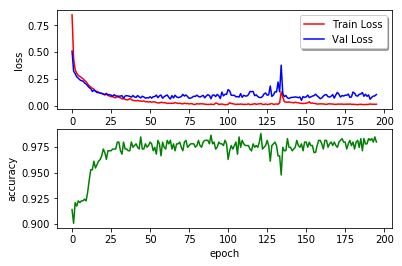

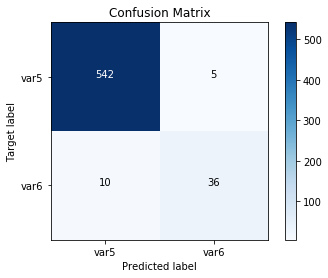

EPOCH: 197
TRAIN LOSS: 0.009657326270627964
VAL LOSS: 0.08965202416087417
VAL ACCURACY: 97.9 %
TIME: 13.0 s


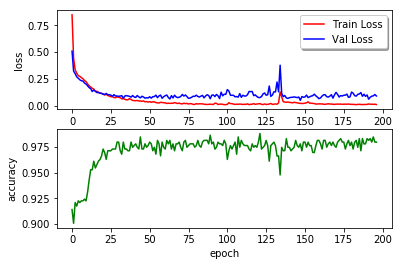

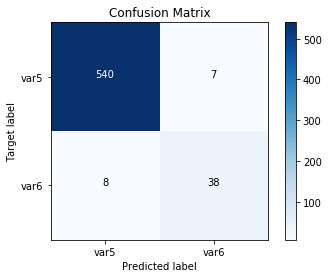

EPOCH: 198
TRAIN LOSS: 0.01066853950022207
VAL LOSS: 0.08701642050854133
VAL ACCURACY: 97.2 %
TIME: 12.5 s


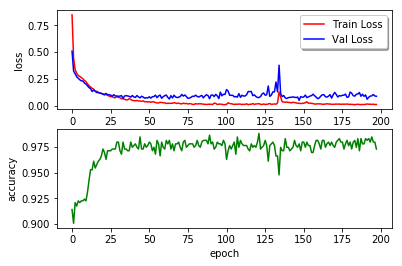

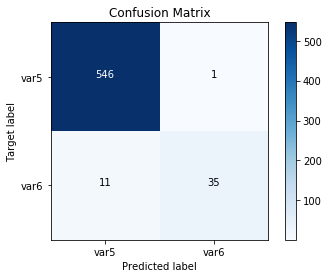

EPOCH: 199
TRAIN LOSS: 0.014574118182506271
VAL LOSS: 0.09139157197505228
VAL ACCURACY: 97.9 %
TIME: 13.5 s


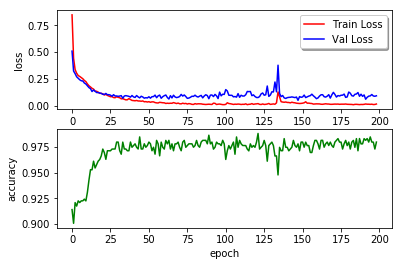

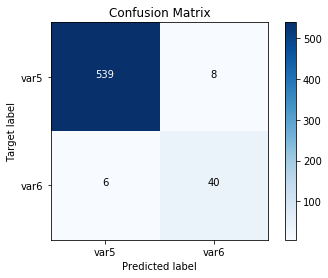

BEST VAL ACCURACY: 98.8 % EPOCH: 122
Final results:
  test loss:			0.111686
  test accuracy:		96.80 %
TRAINING DONE!


In [15]:
import time
import sklearn
import numpy 
import matplotlib.pyplot as plt
import numpy as np
###################### TRAINING #########################
print ("START TRAINING...")
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(1,200):
 
    #start timer
    start = time.time()
    
    #reset confusion matrix
    clearConfusionMatrix()
 
    #iterate over train split batches and calculate mean loss for epoch
    t_l = []
    for image_batch, target_batch in getNextImageBatch():
 
        #calling the training functions returns the current loss
        l = train_net(image_batch, target_batch)
        t_l.append(l)
 
    #we validate our net every epoch and pass our validation split through as well
    v_l = []
    v_a = []
    for image_batch, target_batch in getNextImageBatch(VAL):
  
        #calling the test function returns the net output, loss and accuracy
        prediction_batch, l, a = test_net(image_batch, target_batch)
        v_l.append(l)
        v_a.append(a)
         
        #save predicions and targets for confusion matrix
        
        updateConfusionMatrix(target_batch,prediction_batch)
    
    #mlxtend confusion matrix
    #cm=confusion_matrix(target_batch,prediction_batch)
    #    fig,ax=plot_confusion_matrix(conf_mat=cm)
      #  plt.show()
        
        #pandas_ml confusion matrix
        #confusion_matrix1 = ConfusionMatrix(target_batch,prediction_batch)
        #print("Confusion matrix:\n%s" % confusion_matrix1)
        
    #stop timer
    end = time.time()
 
    #calculate stats for epoch
    train_loss.append(np.mean(t_l))
    val_loss.append(np.mean(v_l))
    val_accuracy.append(np.mean(v_a))
 
    #print stats for epoch
    print ("EPOCH:", epoch,)
    print ("TRAIN LOSS:", train_loss[-1],)
    print ("VAL LOSS:", val_loss[-1],)
    print ("VAL ACCURACY:", (int(val_accuracy[-1] * 1000) / 10.0), "%",)
    print ("TIME:", (int((end - start) * 10) / 10.0), "s")
 
    #show chart
    showChart(epoch, train_loss, val_loss, val_accuracy)
    
    #show confusion matrix
    showConfusionMatrix()

    #show best accuracy and epoch
print ("BEST VAL ACCURACY:", (int(max(val_accuracy) * 1000) / 10.0), "%", "EPOCH:", val_accuracy.index(max(val_accuracy)) + 1)

#####TESTING DATA#######
test_err = 0
test_acc = 0
test_batches = 0
for image_batch, target_batch in getNextImageBatch1():
    test_batch, err, acc = test_net(image_batch, target_batch)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
print ("TRAINING DONE!") 

In [73]:
from sklearn.utils.class_weight import compute_sample_weight
y =  ['ACEP', 'CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR', 'T2CEP']
compute_sample_weight(class_weight='unbalanced', y=y)

array([1., 1., 1., 1., 1., 1., 1.])

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')